In [27]:
import os

import torch
import numpy as np
import pandas as pd
import autoreject

import mne
from mne_bids import BIDSPath

import scipy.io
import scipy
import scipy.signal

from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
plt.style.use('dark_background')

import re
import multiprocessing
from joblib import Parallel, delayed


from collections import Counter

import random

mae3, mit source estimation. 

In [28]:
# data_path = "/vol/aimspace/users/dena/Documents/clean_brain_age/raw_data/CHBP"
data_path = "/vol/aimspace/users/dena/Documents/clean_brain_age/brain-age-benchmark/processed_TUAB"

save_path = "/vol/aimspace/users/dena/Documents/mae/data/tuab_with_mne_and_autoreject_and_normalization"

n_jobs = 16

SMALL_DATASET = False
if SMALL_DATASET: 
    save_path +="_small_5"

if not os.path.exists(save_path):  
    os.makedirs(save_path)

save_path

'/vol/aimspace/users/dena/Documents/mae/data/tuab_with_mne_and_autoreject_and_normalization'

### Parse the header file

In [29]:
participant_tab_data = pd.read_csv(os.path.join(data_path, "participants.tsv"), sep="\t", index_col=0) 
participant_tab_data[:5]

,age,sex,hand,weight,height
participant_id,,,,,
sub-aaaaaaav,35,F,NaN,NaN,NaN
sub-aaaaaabn,24,F,NaN,NaN,NaN
sub-aaaaaaff,53,M,NaN,NaN,NaN
sub-aaaaaalk,51,F,NaN,NaN,NaN
sub-aaaaaama,36,M,NaN,NaN,NaN


In [30]:

labels_dict = {}
for idx in range(len(participant_tab_data)):
    key = participant_tab_data.index[idx]
    sex = participant_tab_data.iloc[idx]["sex"]
    age = participant_tab_data.iloc[idx]["age"] #.split("-")], dtype=np.float32).mean()

    labels_dict[key] = (age, sex)
print(len(labels_dict))
display(list(labels_dict.items())[:5])

torch.save(labels_dict, os.path.join(save_path, "labels_dict.pt"))

1385


[('sub-aaaaaaav', (35, 'F')),
 ('sub-aaaaaabn', (24, 'F')),
 ('sub-aaaaaaff', (53, 'M')),
 ('sub-aaaaaalk', (51, 'F')),
 ('sub-aaaaaama', (36, 'M'))]

### Create the raw dataset (WORKS WITHOUT LABELS_DICT) 

In [31]:
def get_all_files(rootdir): #, substring):
    files = []
    for file in os.listdir(rootdir):
        curr_object = os.path.join(rootdir, file)

        if os.path.isdir(curr_object) and (curr_object.split("-")[0] == "sub" or curr_object == "eeg"):
            files += get_all_files(curr_object) #, substring)
        # elif substring in file and ".set" in file:
        #     files.append(curr_object)

    return files

In [32]:
first_iteration_subj_ids = []
files = []
edf_files = []
channels_tsv = []

for file in os.listdir(data_path):
    # print(file)
    first_iteration_subj_ids.append(file)

for subj in first_iteration_subj_ids: 
    curr_path = os.path.join(os.path.join(data_path, subj, "ses-001", "eeg"))
    if os.path.isdir(curr_path): 
        buffer = 0
        for file in os.listdir(curr_path):
            if file.split(".")[-1] == "vhdr": 
                edf_files.append(os.path.join(curr_path, file))
                buffer += 1
        if buffer == 0: 
            print("EEG folder but no vhdr file?: " + file)
            
            
        if file.split("_")[-1] == "channels.tsv": 
            channels_tsv.append(file)

print(len(edf_files))

1385


In [33]:
if SMALL_DATASET: 
    edf_files = edf_files[:5]

print(len(edf_files))

1385


In [34]:
analyze_channels = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1',
                    'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'A1', 'A2',
                    'Fz', 'Cz', 'Pz']

In [35]:
fs_dir = mne.datasets.fetch_fsaverage(verbose=True)
subjects_dir = os.path.dirname(fs_dir)
subject = 'fsaverage'
trans = 'fsaverage'  # fsaverage has a built-in identity transform

0 files missing from root.txt in /vol/aimspace/users/dena/Documents/clean_brain_age/brain-age-benchmark/subjects_dir_mne_pipeline
0 files missing from bem.txt in /vol/aimspace/users/dena/Documents/clean_brain_age/brain-age-benchmark/subjects_dir_mne_pipeline/fsaverage


In [36]:
montage = mne.channels.make_standard_montage('standard_1005') # for TUAB

In [37]:
# all three are independent of the EEG. Since we are using fsaverage, there is no need to seperate between individuals (i.e. to include it in loop) 
src = mne.setup_source_space(subject, spacing='oct6', subjects_dir=subjects_dir, add_dist=False)
model = mne.make_bem_model(subject=subject, subjects_dir=subjects_dir)
bem = mne.make_bem_solution(model)

Setting up the source space with the following parameters:

SUBJECTS_DIR = /vol/aimspace/users/dena/Documents/clean_brain_age/brain-age-benchmark/subjects_dir_mne_pipeline
Subject      = fsaverage
Surface      = white
Octahedron subdivision grade 6

>>> 1. Creating the source space...

Doing the octahedral vertex picking...
Loading /vol/aimspace/users/dena/Documents/clean_brain_age/brain-age-benchmark/subjects_dir_mne_pipeline/fsaverage/surf/lh.white...
Mapping lh fsaverage -> oct (6) ...
    Triangle neighbors and vertex normals...
Loading geometry from /vol/aimspace/users/dena/Documents/clean_brain_age/brain-age-benchmark/subjects_dir_mne_pipeline/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
loaded lh.white 4098/163842 selected to source space (oct = 6)

Loading /vol/aimspace/users/dena/Documents/clean_brain_age/brain-age-benchmark/subjects_dir_mne_pipeline/fsaverage/surf/rh.white...
Mapping rh fsaverage -> oct (6) ...
    Triangle neighbors a

In [38]:
epoch_length = 10  # in seconds
SAVE = True
path_to_save = save_path
path_to_save

'/vol/aimspace/users/dena/Documents/mae/data/tuab_with_mne_and_autoreject_and_normalization'

In [39]:
# w.o. parallel: 1min6sec for 5 files (before autoreject)
# w.o. parallel: 4,8h for all files (before autoreject) 
# Ran already with autoreject - however it is uncertain how long it took. Since the script died twice, it may be that 2*4 subjects were hurt. 
skipped_subjects = []


def process_edf_file(edf_filename):
    subject_id = edf_filename.split("/")[-1].split("_")[0].split("-")[1]

    if not os.path.exists(f'{path_to_save}/{subject_id}/epochs-epo.fif'):  
        print(f"Processing {subject_id}. ")

        resample_freq = 200 # Hz for TUAB

        # Read the EEG data from the .edf file
        raw = mne.io.read_raw_brainvision(edf_filename, verbose=False, preload=True)
        raw.set_montage(montage)

        # Check if all channels are there
        to_analyze_channels_not_in_raw_ch_names = list(set(analyze_channels) - set(raw.ch_names))
        if to_analyze_channels_not_in_raw_ch_names:
            raise ValueError(f"Subject {subject_id} does not have all necessary channels. Missing channels: {to_analyze_channels_not_in_raw_ch_names}")
            
        raw.pick(analyze_channels, verbose=False).resample(sfreq=resample_freq, verbose=False)
        raw.filter(0.1, 49)

        fwd = mne.make_forward_solution(raw.info, trans=trans, src=src, bem=bem, eeg=True, mindist=5.0)
        # EEG average reference (using a projector) is mandatory for modeling (inverse etc) >> will otherwise raise error later on. 
        # Config file basically took every channel as reference, as far as I could gather
        raw.set_eeg_reference('average', projection=True)
        raw.apply_proj()

        ### Divide recording into 10 second epochs:
        # Create events array: [[sample1, 0, event_id], [sample2, 0, event_id], ...]
        event_id = 1  # could be any integer as event id
        num_samples = len(raw.times)
        events = np.array([
            [i, 0, event_id] for i in range(0, num_samples, int(raw.info['sfreq'] * epoch_length))
        ])

        epochs = mne.Epochs(raw, events, event_id, tmin=0, tmax=epoch_length, baseline=None, preload=True)

        #########################
        #  EXPERIMENT (NOT IN MNE BIDS PIPELINE): NORMALIZE EPOCHS!

        # Mean, std, z-score normalization
        data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)
        mean = np.mean(data, axis=(0, 2), keepdims=True)
        std = np.std(data, axis=(0, 2), keepdims=True)
        normalized_data = (data - mean) / std

        # Replace data in epochs
        epochs._data = normalized_data

        #########################
        
        cov = mne.make_ad_hoc_cov(raw.info) 

        # Those two lines are from the Benchmarking algo
        ar = autoreject.AutoReject(n_jobs=1, cv=5)
        epochs = ar.fit_transform(epochs)

        inv = mne.minimum_norm.make_inverse_operator(epochs.info, fwd, cov, loose=0.2, depth=0.8)
        #config file says this is unnecessary? 
        stc = mne.minimum_norm.apply_inverse(epochs.average(), inv, lambda2=1.0 / 9.0, method='dSPM')

        if SAVE:
            if not os.path.exists(os.path.join(path_to_save, subject_id)):
                os.makedirs(os.path.join(path_to_save, subject_id))
            epochs.save(f'{path_to_save}/{subject_id}/epochs-epo.fif', overwrite=True)
            stc.save(f'{path_to_save}/{subject_id}/source_estimate', overwrite=True)
            mne.write_forward_solution(f'{path_to_save}/{subject_id}/forward_model-fwd.fif', fwd, overwrite=True)
            mne.minimum_norm.write_inverse_operator(f'{path_to_save}/{subject_id}/inverse_operator-inv.fif', inv, overwrite=True)
    else: 
        skipped_subjects.append(subject_id)
        print(f"Skipped {subject_id}. ")

    

if __name__ == "__main__": 
    pool = multiprocessing.Pool(processes=n_jobs)

    # Parallel processing using multiprocessing.Pool
    pool.map(process_edf_file, edf_files)
    # Close the pool of processes
    pool.close()
    pool.join()

Processing aaaaamji. 
Processing aaaaamlm. Processing aaaaamoq. Processing aaaaajjb. Processing aaaaanfh. Processing aaaaalkt. Processing aaaaaoyh. Processing aaaaaluz. Processing aaaaapbm. Processing aaaaamhh. Processing aaaaalqa. Processing aaaaaopf. Processing aaaaaoxx. Processing aaaaaoxf. 












Processing aaaaaone. 
Processing aaaaaokw. 
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 6601 samples (33.005 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.
Processing aaaaancz. 
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49 Hz

FIR filter parame

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


- Upper passband edge: 49.00 Hz

FIR filter parameters
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
---------------------
- Filter length: 6601 samples (33.005 s)

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
Filtering raw data in 1 contiguous segment
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
Setting up band-pass filter from 0.1 - 49 Hz
- Upper passband edge: 49.00 Hz

- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
FIR filter parameters
- Filter length: 6601 samples (33.005 s)

---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


- Filter length: 6601 samples (33.005 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 6601 samples (33.005 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Head coordinate coil definitions created.
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Read 2 source spaces a total of 8196 active source locations
Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif

Measurement data      : instance of Info
Coordinate transformation: MRI (surface RAS) -> head
Conductor model   : instance of ConductorModel
     0.999994  0.003552  0.000202      -1.76 mm
Accurate field computations
    -0.003558  0.998389  0.056626      31.09 mm
Do computations in head coordinates
    -0.000001 -0.056626  0.998395      39.60 mm
Free source orientations
     0.000000  0.000000  0.000000       1.00




[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Read  21 EEG channels from info
Head coordinate coil definitions created.
Read 2 source spaces a total of 8196 active source locations
Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif

Measurement data      : instance of Info
Coordinate transformation: MRI (surface RAS) -> head
Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
Conductor model   : instance of ConductorModel
     0.999994  0.003552  0.000202      -1.76 mm
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Accurate field computations
Measurement data 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00
Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
Head coordinate coil definitions created.
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif

Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Read  21 EEG channels from info
Accurate field computations
Do computations in head coordinates
Head coordinate coil definitions created.
Free source orientations

Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/li

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Read  21 EEG channels from info
Head coordinate coil definitions created.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.
Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Free source orientations

Read 2 source spaces a total of 8196 active source locations
Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif

Measurement data      : instance of Info
Coordinate transformation: MRI (surface RAS) -> head
Conductor model   : instance of ConductorModel
     0.999994  0.003552  0.000202      -1.76 mm
Accurate field computations
Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
    -0.003558  0.998389  0.056626      31.09 mm
Do computations in head coordinates
    -0.000001 -0.056626  0.998395      39.60 mm
MRI -> head transform : /u/home/dena/.conda/envs/mae3/l

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Processing aaaaamor. 
Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
Processing aaaaapfu. Processing aaaaadna. Processing aaaaakkv. MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif



Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations
Processing aaaaanew. Processing aaaaajfi. 


Read 2 source spaces a total of 8196 active source locations
Processing aaaaaplm. 

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Processing aaaaapik. Processing aaaaanvl. Read  

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Checking surface interior status for 4098 points...
    Found  999/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3099 points outside using surface Qhull
Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49 Hz

FIR filter parameters
-----------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Checking surface interior status for 4098 points...
    Found  999/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3099 points outside using surface Qhull
Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
Setting up for EEG...
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Source spaces are now in head coordinates.

Checking surface interior status for 4098 points...
    Found  999/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3099 points outside using surface Qhull
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 6601 samples (33.005 s)
Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] M

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


- Filter length: 6601 samples (33.005 s)

Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel is now set up
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
Checking surface interior status for 4098 points...
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)

    Found  999/4098 points inside  an interior sphere of radius   47.7 mm
Source spaces are in head coordinates.
- Upper passband edge: 49.00 Hz
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff fr

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Free source orientations

Read 2 source spaces a total of 8196 active source locations



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.
Checking surface interior status for 4098 points...
Filtering raw data in 1 contiguous segment
    Found  999/4098 points inside  an interior sphere of radius   47.7 mm
Setting up band-pass filter from 0.1 - 49 Hz

Source spaces are now in head coordinates.

FIR filter parameters
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3099 points outside using surface Qhull
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 6601 samples (33.005 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations
Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>

MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Coordinate transformation: MRI (surface RAS) -> head
Measurement data      : instance of Info
     0.999994  0.003552  0.000202   

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Source spaces are now in head coordinates.

    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2093.9 ms
Source spaces are now in head coordinates.


Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel is now set up


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s



Source spaces are in head coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 6601 samples (33.005 s)

Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fs

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Checking surface interior status for 4098 points...
    Found  999/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3099 points outside using surface Qhull
Checking surface interior status for 4098 points...
    Found  999/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3099 points outside using surface Qhull
Checking surface interior status for 4098 points...
Computing EEG at 8196 source locations (free orientations)...
    Found  999/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3099 points outside using surface Qhull
Checking surface interior status for 4098 points...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


    Found  999/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3099 points outside using surface Qhull
Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel is now set up

Source spaces are in head coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel is now set up
Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif

Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computat

/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2375.6 ms
Checking surface interior status for 4098 points...
    Found  906/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3192 points outside using surface Qhull
Running autoreject on ch_type=eeg
    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2546.8 ms


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]


Setting up for EEG...

Finished.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Computing EEG at 8196 source locations (free orientations)...
SSP projectors applied...
Not setting metadata
124 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 124 events and 2001 original time points ...
    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 1811.8 ms

Setting up for EEG...
Computing EEG at 8196 source locations (free orientations)...
    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check c

/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)



Running autoreject on ch_type=eeg
Setting up for EEG...


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

Computing EEG at 8196 source locations (free orientations)...
    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 3416.5 ms

Setting up for EEG...
Computing EEG at 8196 source locations (free orientations)...
1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]


Finished.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Not setting metadata
134 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 134 events and 2001 original time points ...

Finished.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Not setting metadata
128 matching events found
No baseline correction applied
Creat

/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


Running autoreject on ch_type=eeg
1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

Running autoreject on ch_type=eeg1 bad epochs dropped



/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


Running autoreject on ch_type=eeg

  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


Running autoreject on ch_type=eeg
1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


Running autoreject on ch_type=eeg
1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


Running autoreject on ch_type=eeg
1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/122 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/122 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/122 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/122 [00:00<?,       ?it/s]

/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/bem.py:1134: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]





Estimated consensus=0.50 and n_interpolate=4


  0%|          | Repairing epochs : 0/122 [00:00<?,       ?it/s]

Dropped 7 epochs: 2, 10, 23, 24, 25, 29, 66
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 21 channels.
    21 out of 21 channels remain after picking
Selected 21 channels
Creating the depth weighting matrix...
    21 EEG channels
    limit = 8197/8196 = 2.202935
    scale = 52774.2 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 1.9e-18 (2.2e-16 eps * 21 dim * 0.0004  max singular value)
    Estimated rank (eeg): 20
    EEG: rank 20 computed from 21 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusti

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Employing the head->MRI coordinate transform with the BEM model.
BEM model instance 

  0%|          | Repairing epochs : 0/123 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 1912.7 ms


  0%|          | Repairing epochs : 0/123 [00:00<?,       ?it/s]

Checking surface interior status for 4098 points...
    Found  906/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3192 points outside using surface Qhull


  0%|          | Repairing epochs : 0/108 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/108 [00:00<?,       ?it/s]

    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2248.9 ms



  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

Setting up for EEG...
Computing EEG at 8196 source locations (free orientations)...


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/123 [00:00<?,       ?it/s]


Finished.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Not setting metadata
133 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 133 events and 2001 original time points ...
1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


  0%|          | Repairing epochs : 0/108 [00:00<?,       ?it/s]

Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/123 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/108 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/118 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=4


  0%|          | Repairing epochs : 0/123 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/118 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]





Estimated consensus=0.30 and n_interpolate=4


  0%|          | Repairing epochs : 0/108 [00:00<?,       ?it/s]

Dropped 2 epochs: 6, 7
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 21 channels.
    21 out of 21 channels remain after picking
Selected 21 channels
Creating the depth weighting matrix...
    21 EEG channels
    limit = 8197/8196 = 2.202935
    scale = 52774.2 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 1.9e-18 (2.2e-16 eps * 21 dim * 0.0004  max singular value)
    Estimated rank (eeg): 20
    EEG: rank 20 computed from 21 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance 

  0%|          | Repairing epochs : 0/126 [00:00<?,       ?it/s]

    largest singular value = 2.61234
    scaling factor to adjust the trace = 1.1248e+22 (nchan = 21 nzero = 1)


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 121
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 20 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Dropped 9 epochs: 4, 5, 6, 7, 9, 13, 14, 40, 50
Applying inverse operator to "1"...
    Picked 21 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 21 channels.
    21 out of 21 channels remain after picking
Selected 21 channels
Creating the depth weighting matrix...
    21 EEG channels
    Computing residual...
    limit

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

Writing STC to disk...
    Computing residual...
    Explained  96.4% variance
    Combining the current components...


  0%|          | Repairing epochs : 0/126 [00:00<?,       ?it/s]

    dSPM...
[done]


  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

Writing STC to disk...
[done]
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written


  0%|          | Repairing epochs : 0/118 [00:00<?,       ?it/s]

Write inverse operator decomposition in /vol/aimspace/users/dena/Documents/mae/data/tuab_with_mne_and_autoreject_and_normalization/aaaaalqv/inverse_operator-inv.fif...
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
    Writing inverse operator info...
    Writing noise covariance matrix.
    Writing source covariance matrix.
    Writing orientation priors.
    [done]


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

Processing aaaaaojz. 


  0%|          | Repairing epochs : 0/127 [00:00<?,       ?it/s]

[done]
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
Write inverse operator decomposition in /vol/aimspace/users/dena/Documents/mae/data/tuab_with_mne_and_autoreject_and_normalization/aaaaanvl/inverse_operator-inv.fif...
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
    Writing source covariance matrix.
    Writing inverse operator info...
    Writing noise covariance matrix.
    Writing orientation priors.
    [done]


  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/127 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

Processing aaaaapql. 


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/126 [00:00<?,       ?it/s]

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 6601 samples (33.005 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


  0%|          | Repairing epochs : 0/127 [00:00<?,       ?it/s]

Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.



  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel is now set up

Source spaces are in head coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
Checking surface interior status for 4098 points...
    Found  999/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3099 points outside using surface Qhull


  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/127 [00:00<?,       ?it/s]

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 6601 samples (33.005 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel


  0%|          | Repairing epochs : 0/118 [00:00<?,       ?it/s]

Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.



/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/bem.py:1134: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel is now set up

Source spaces are in head coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
Checking surface interior status for 4098 points...
    Found  999/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3099 points outside using surface Qhull


  0%|          | Repairing epochs : 0/133 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2588.2 ms
Checking surface interior status for 4098 points...
    Found  906/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3192 points outside using surface Qhull


  0%|          | Repairing epochs : 0/133 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/127 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2626.1 ms
Checking surface interior status for 4098 points...
    Found  906/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3192 points outside using surface Qhull




Estimated consensus=0.40 and n_interpolate=1


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/118 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/137 [00:00<?,       ?it/s]

    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2684.2 ms


  0%|          | Repairing epochs : 0/126 [00:00<?,       ?it/s]


Setting up for EEG...
Computing EEG at 8196 source locations (free orientations)...


/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/bem.py:1134: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/138 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/137 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/bem.py:1134: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2844.3 ms



  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

Setting up for EEG...
Computing EEG at 8196 source locations (free orientations)...


  0%|          | Repairing epochs : 0/138 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/127 [00:00<?,       ?it/s]

Dropped 8 epochs: 4, 9, 12, 14, 32, 34, 85, 86


/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/bem.py:1134: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 21 channels.
    21 out of 21 channels remain after picking
Selected 21 channels
Creating the depth weighting matrix...
    21 EEG channels
    limit = 8197/8196 = 2.202935
    scale = 52774.2 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 1.9e-18 (2.2e-16 eps * 21 dim * 0.0004  max singular value)
    Estimated rank (eeg): 20
    EEG: rank 20 computed from 21 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD o

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]





Estimated consensus=0.30 and n_interpolate=4


  0%|          | Repairing epochs : 0/139 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/127 [00:00<?,       ?it/s]

/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/bem.py:1134: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()


  0%|          | Repairing epochs : 0/126 [00:00<?,       ?it/s]

/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

    largest singular value = 2.61234
    scaling factor to adjust the trace = 1.1248e+22 (nchan = 21 nzero = 1)
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 110
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 20 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...

Finished.
EEG channel type selected for re-referencing
[done]
Adding average EEG reference projection.
Applying inverse operator to "1"...
1 projection items deactivated
    Picked 21 channels from the data
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
    Computing inverse...
    Eigenleads need to be weighted ...
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Not setting metadata
129 matching events found
No ba

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

    dSPM...
[done]


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/133 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]





Estimated consensus=0.20 and n_interpolate=4


  0%|          | Repairing epochs : 0/139 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

Writing STC to disk...




Estimated consensus=0.70 and n_interpolate=4


  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/151 [00:00<?,       ?it/s]


Finished.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Not setting metadata
135 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 135 events and 2001 original time points ...
1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


Running autoreject on ch_type=eeg


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

[done]


  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written


  0%|          | Repairing epochs : 0/151 [00:00<?,       ?it/s]

Write inverse operator decomposition in /vol/aimspace/users/dena/Documents/mae/data/tuab_with_mne_and_autoreject_and_normalization/aaaaakkv/inverse_operator-inv.fif...
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
    Writing inverse operator info...
    Writing noise covariance matrix.
    Writing source covariance matrix.
    Writing orientation priors.
    [done]
Processing aaaaaiwp. 


  0%|          | Repairing epochs : 0/137 [00:00<?,       ?it/s]

Dropped 38 epochs: 1, 5, 8, 13, 15, 22, 23, 32, 36, 47, 73, 75, 76, 77, 78, 79, 83, 86, 90, 92, 93, 95, 97, 98, 99, 100, 101, 102, 103, 104, 105, 107, 108, 109, 110, 111, 113, 120
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 21 channels.
    21 out of 21 channels remain after picking
Selected 21 channels
Creating the depth weighting matrix...
    21 EEG channels
    limit = 8197/8196 = 2.202935
    scale = 52774.2 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

Computing rank from covariance with rank=None
    Using tolerance 1.9e-18 (2.2e-16 eps * 21 dim * 0.0004  max singular value)
    Estimated rank (eeg): 20
    EEG: rank 20 computed from 21 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.




Estimated consensus=0.60 and n_interpolate=4
Filtering raw data in 1 contiguous segment
1 bad epochs dropped
Setting up band-pass filter from 0.1 - 49 Hz



/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 6601 samples (33.005 s)

Running autoreject on ch_type=eeg


  0%|          | Repairing epochs : 0/127 [00:00<?,       ?it/s]

  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.



  0%|          | Repairing epochs : 0/127 [00:00<?,       ?it/s]

Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel is now set up

Source spaces are in head coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
Checking surface interior status for 4098 points...
    Found  999/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3099 points outside using surface Qhull
Dropped 8 epochs: 2, 6, 31, 32, 35, 37, 38, 39
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 21 channels.
    21 out of 21 channels remain after picking
Selected 21 channels
Creating the depth weighting matrix...
    21 EEG channels
Dropped 81 epochs: 0, 

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

    EEG: rank 20 computed from 21 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
    21 EEG channels
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    limit = 8197/8196 = 2.202935
    scale = 52774.2 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 1.9e-18 (2.2e-16 eps * 21 dim * 0.0004  max singular value)
    Estimated rank (eeg): 20
    EEG: rank 20 computed from 21 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 2.61234
    scaling factor to adjust the trace = 1.1248e+22 (nchan = 21 nzero

  0%|          | Repairing epochs : 0/138 [00:00<?,       ?it/s]

[done]
Applying inverse operator to "1"...
    Picked 21 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  97.8% variance
    Combining the current components...
    dSPM...
[done]
Writing STC to disk...
    largest singular value = 2.61234
    scaling factor to adjust the trace = 1.1248e+22 (nchan = 21 nzero = 1)
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 112
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 20 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 3049.2 ms
Checking surface interior status for 4098 points...
    Found  906/4098 points inside  an interior sphere of radius  

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

    Computing residual...
[done]
Applying inverse operator to "1"...
    Picked 21 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

    Computing residual...
    Explained  96.8% variance
    Combining the current components...


  0%|          | Repairing epochs : 0/160 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/133 [00:00<?,       ?it/s]

    Explained  95.0% variance
    Combining the current components...
    dSPM...
[done]
    dSPM...
[done]
[done]
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
Writing STC to disk...
Dropped 30 epochs: 0, 3, 4, 5, 6, 12, 32, 37, 39, 48, 51, 52, 58, 59, 64, 66, 67, 68, 69, 70, 71, 84, 96, 97, 103, 105, 107, 109, 111, 113


  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/bem.py:1134: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()


Writing STC to disk...


  0%|          | Repairing epochs : 0/160 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/139 [00:00<?,       ?it/s]

Write inverse operator decomposition in /vol/aimspace/users/dena/Documents/mae/data/tuab_with_mne_and_autoreject_and_normalization/aaaaaoxb/inverse_operator-inv.fif...


/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

Converting forward solution to surface orientation
    Write a source space...
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]


/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


    Write a source space...
    [done]
    2 source spaces written
    Writing inverse operator info...
    [done]
    Writing noise covariance matrix.
Computing inverse operator with 21 channels.
    Writing source covariance matrix.
    Writing orientation priors.
    21 out of 21 channels remain after picking
    [done]
Selected 21 channels
Creating the depth weighting matrix...
    21 EEG channels
    limit = 8197/8196 = 2.202935
    scale = 52774.2 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 1.9e-18 (2.2e-16 eps * 21 dim * 0.0004  max singular value)
    Estimated rank (eeg): 20
    EEG: rank 20 computed from 21 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and we

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2415.0 ms



  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

Setting up for EEG...
Processing aaaaamdd. Computing EEG at 8196 source locations (free orientations)...



  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

    largest singular value = 2.61234
    scaling factor to adjust the trace = 1.1248e+22 (nchan = 21 nzero = 1)
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 97
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 20 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...




Estimated consensus=0.80 and n_interpolate=4
[done]
Applying inverse operator to "1"...
    Picked 21 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...


  0%|          | Repairing epochs : 0/127 [00:00<?,       ?it/s]

    Computing residual...
[done]
    Explained  94.9% variance
    Combining the current components...
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
    dSPM...
[done]


  0%|          | Repairing epochs : 0/137 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

[done]
Write inverse operator decomposition in /vol/aimspace/users/dena/Documents/mae/data/tuab_with_mne_and_autoreject_and_normalization/aaaaamor/inverse_operator-inv.fif...
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
    Writing inverse operator info...
    Writing noise covariance matrix.
    Writing source covariance matrix.
    Writing orientation priors.
    [done]
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written




Estimated consensus=0.50 and n_interpolate=4


  0%|          | Repairing epochs : 0/133 [00:00<?,       ?it/s]

Writing STC to disk...


  0%|          | Repairing epochs : 0/151 [00:00<?,       ?it/s]

Write inverse operator decomposition in /vol/aimspace/users/dena/Documents/mae/data/tuab_with_mne_and_autoreject_and_normalization/aaaaapik/inverse_operator-inv.fif...
    Write a source space...
Processing aaaaansy. 
    [done]
    Write a source space...
    [done]
    2 source spaces written
    Writing inverse operator info...
    Writing noise covariance matrix.
    Writing source covariance matrix.
    Writing orientation priors.
    [done]


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 6601 samples (33.005 s)

Processing aaaaajvp. 


  0%|          | Repairing epochs : 0/138 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Employing the head->MRI coordinate transform with the BEM model.
BEM model instance 

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

Write inverse operator decomposition in /vol/aimspace/users/dena/Documents/mae/data/tuab_with_mne_and_autoreject_and_normalization/aaaaanew/inverse_operator-inv.fif...
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
    Writing inverse operator info...
    Writing noise covariance matrix.
    Writing source covariance matrix.
    Writing orientation priors.
    [done]

Finished.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Dropped 17 epochs: 0, 3, 4, 5, 14, 15, 47, 59, 60, 103, 104, 107, 108, 109, 116, 124, 125
Processing aaaaaoez. 
SSP projectors applied...
Not setting metadata
131 matching events found
No baseline correction applied
Created an SSP operator (subspace dimens

/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/bem.py:1134: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()


Using data from preloaded Raw for 131 events and 2001 original time points ...

FIR filter parameters


/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method


/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
    [done]
- Lower passband edge: 0.10
Computing inverse operator with 21 channels.
    21 out of 21 channels remain after picking
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
Selected 21 channels
Creating the depth weighting matrix...
    21 EEG channels
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 6601 samples (33.005 s)

    limit = 8197/8196 = 2.202935
    scale = 52774.2 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 1.9e-18 (2.2e-16 eps * 21 dim * 0.0004  max singular value)
    Estimated rank (eeg): 20
    EEG: rank 20 computed from 21 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Crea

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

Computing SVD of whitened and weighted lead field matrix.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49 Hz

FIR filter parameters
---------------------


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 6601 samples (33.005 s)

Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate tr

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Conductor model   : instance of ConductorModel
Measurement data      : instance of Info
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.




Estimated consensus=0.10 and n_interpolate=1Employing the head->MRI coordinate transform with the BEM model.
BEM model insta

  0%|          | Repairing epochs : 0/137 [00:00<?,       ?it/s]

Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel is now set up
1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)



Source spaces are in head coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
Running autoreject on ch_type=eeg
Checking surface interior status for 4098 points...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49 Hz

    Found  999/4098 points inside  an interior sphere of radius   47.7 mm
FIR filter parameters
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3099 points outside using surface Qhull


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 6601 samples (33.005 s)

Dropped 14 epochs: 7, 8, 9, 24, 34, 36, 37, 38, 39, 45, 64, 86, 106, 128
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 21 channels.
    21 out of 21 channels remain after picking
Selected 21 channels
Creating the depth weighting matrix...
    21 EEG channels


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


    largest singular value = 2.61234
    scaling factor to adjust the trace = 1.1248e+22 (nchan = 21 nzero = 1)
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 110
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)


  0%|          | Repairing epochs : 0/139 [00:00<?,       ?it/s]

    Created the whitener using a noise covariance matrix with rank 20 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
    limit = 8197/8196 = 2.202935
    scale = 52774.2 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 1.9e-18 (2.2e-16 eps * 21 dim * 0.0004  max singular value)
    Estimated rank (eeg): 20
Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
    EEG: rank 20 computed from 21 data channels with 1 projector
    Found    0/3099 points outside using solid angles
Measurement data      : instance of Info
    S

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

Checking surface interior status for 4098 points...
    Found  999/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3099 points outside using surface Qhull
    dSPM...
[done]
Writing STC to disk...
    largest singular value = 2.61234
    scaling factor to adjust the trace = 1.1248e+22 (nchan = 21 nzero = 1)
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 119
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 20 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

[done]
Applying inverse operator to "1"...
    Picked 21 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2280.0 ms
Checking surface interior status for 4098 points...
    Found  906/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3192 points outside using surface Qhull
    Computing residual...
    Explained  97.5% variance
    Combining the current components...




Estimated consensus=0.30 and n_interpolate=4
    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2383.2 ms
Checking surface interior status for 4098 points...
    Found  906/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere 

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/138 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/160 [00:00<?,       ?it/s]

[done]
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
Dropped 49 epochs: 0, 1, 2, 3, 4, 5, 9, 10, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 28, 30, 31, 32, 33, 35, 36, 37, 39, 40, 43, 44, 47, 50, 53, 55, 58, 59, 60, 64, 92, 106, 112, 117, 119, 129, 131, 133
    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2403.2 ms

Setting up for EEG...
Computing EEG at 8196 source locations (free orientations)...


  0%|          | Repairing epochs : 0/181 [00:00<?,       ?it/s]

Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
Writing STC to disk...
    Converting to surface-based source orientations...
Write inverse operator decomposition in /vol/aimspace/users/dena/Documents/mae/data/tuab_with_mne_and_autoreject_and_normalization/aaaaaplm/inverse_operator-inv.fif...
    Write a source space...
    [done]
    Write a source space...
    [done]
Computing inverse operator with 21 channels.
    21 out of 21 channels remain after picking
    [done]
    2 source spaces written
Selected 21 channels
    Writing inverse operator info...
Creating the depth weighting matrix...
    Writing noise covariance matrix.
    21 EEG channels
    Writing source covariance matrix.
    Writing orientation priors.
    [done]
    limit = 8197/8196 = 2.202935
    scale = 52774.2 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

    Scaled noise and source covariance from nave = 1 to nave = 88
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 20 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "1"...
    Picked 21 channels from the data


  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

    Computing inverse...
    Eigenleads need to be weighted ...
    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2171.5 ms

    Computing residual...
    Explained  94.8% variance
    Combining the current components...
Setting up for EEG...


  0%|          | Repairing epochs : 0/181 [00:00<?,       ?it/s]

Computing EEG at 8196 source locations (free orientations)...




Estimated consensus=0.40 and n_interpolate=1
    dSPM...
[done]


  0%|          | Repairing epochs : 0/139 [00:00<?,       ?it/s]

[done]


  0%|          | Repairing epochs : 0/151 [00:00<?,       ?it/s]

    Write a source space...
    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2385.5 ms
    [done]
    Write a source space...
    [done]
    2 source spaces written

Setting up for EEG...
Writing STC to disk...
Computing EEG at 8196 source locations (free orientations)...
Write inverse operator decomposition in /vol/aimspace/users/dena/Documents/mae/data/tuab_with_mne_and_autoreject_and_normalization/aaaaapbn/inverse_operator-inv.fif...
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
    Writing inverse operator info...
    Writing noise covariance matrix.
    Writing source covariance matrix.
    Writing orientation priors.
    [done]
Processing aaaaanbi. 
    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2333.3 ms

Setting up for EEG...
Computing EEG at 8196 source locatio

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


    [done]
    limit = 8197/8196 = 2.202935
    2 source spaces written
    scale = 52774.2 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 1.9e-18 (2.2e-16 eps * 21 dim * 0.0004  max singular value)
    Estimated rank (eeg): 20
    EEG: rank 20 computed from 21 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
Write inverse operator decomposition in /vol/aimspace/users/dena/Documents/mae/data/tuab_with_mne_and_autoreject_and_normalization/aaaaameg/inverse_operator-inv.fif...
Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00


Read  21 EEG channels from info
Finished.
Head coordinate coil definitions created.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
Source spaces are now in head coordinates.

1 projection items activated
SSP projectors applied...
Not setting metadata
122 matching events found
No baseline correction applied
1 projection items activated
Created an SSP operator (subspace dimension = 1)
Using data from preloaded Raw for 122 events and 2001 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
    Computing residual...
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.
    Explained  96.0% variance
    Combining the current components...
Source spaces are now in head co

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel is now set up

Source spaces are in head coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


    dSPM...
[done]
Running autoreject on ch_type=eeg

Finished.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Checking surface interior status for 4098 points...
    Found  999/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3099 points outside using surface Qhull
SSP projectors applied...
Not setting metadata
130 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 130 events and 2001 original time points ...
Dropped 42 epochs: 0, 4, 6, 7, 12, 15, 16, 22, 24, 25, 26, 27, 29, 32, 33, 34, 35, 37, 39, 40, 41, 42, 43, 47, 50, 5

  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...

Finished.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
    [done]
Computing inverse operator with 21 channels.
    21 out of 21 channels remain after picking
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Selected 21 channels
Creating the depth weighting matrix...
    21 EEG channels
SSP projectors applied...
Not setting metadata
129 matching events found
    limit = 8197/8196 = 2.202935
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
Writing STC to disk...
    scale = 52774.2 exp = 0.8
Applying loose dipole or

  0%|          | Repairing epochs : 0/151 [00:00<?,       ?it/s]

[done]
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]


Finished.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Write inverse operator decomposition in /vol/aimspace/users/dena/Documents/mae/data/tuab_with_mne_and_autoreject_and_normalization/aaaaadna/inverse_operator-inv.fif...
    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 3070.8 ms
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Checking surface interior status for 4098 points...
    Found  906/4098 points inside  an interior sphere of radius   47.7 mm
SSP projectors applied...
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
Not setting metadata
150 matching events found
    Found    0/3192 points outside using surface Qhull
    Write a source space...
No baseline correction 

  0%|          | Repairing epochs : 0/160 [00:00<?,       ?it/s]

    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2620.7 ms
Checking surface interior status for 4098 points...
    Found  906/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3192 points outside using surface Qhull


/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/bem.py:1134: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


    largest singular value = 2.61234


/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


    scaling factor to adjust the trace = 1.1248e+22 (nchan = 21 nzero = 1)
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 97
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 20 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "1"...
    Picked 21 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


    Computing residual...
Running autoreject on ch_type=eeg
    Explained  93.8% variance
    Combining the current components...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49 Hz

FIR filter parameters


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 6601 samples (33.005 s)

    Found    0/3192 points outside using solid angles
    dSPM...
    Total 4098/4098 points inside the surface
Interior check completed in 2990.1 ms
[done]



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Running autoreject on ch_type=eeg
Setting up for EEG...
Read 2 source spaces a total of 8196 active source locations

Writing STC to disk...
Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
Computing EEG at 8196 source locations (free orientations)...
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel is now set up

Source spaces are in head coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2610.1 ms

Checking surface interior status for 4098 points...
    Found  999/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3099 points outside using surface Qhull
Setting up for EEG...
[done]
Computing EEG at 8196 source locations (free orientations)...
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
Write inverse operator decomposition in /vol/aimspace/users/dena/Docu

/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 3214.8 ms
Running autoreject on ch_type=eeg
Processing aaaaamqb. 



  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

Setting up for EEG...
Computing EEG at 8196 source locations (free orientations)...
Dropped 40 epochs: 5, 6, 7, 9, 10, 11, 12, 13, 17, 33, 34, 54, 55, 56, 59, 60, 63, 68, 69, 72, 73, 74, 75, 88, 93, 97, 98, 102, 110, 117, 123, 124, 129, 133, 139, 140, 147, 148, 149, 150
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 21 channels.
    21 out of 21 channels remain after picking
Selected 21 channels
Creating the depth weighting matrix...
    21 EEG channels
    limit = 8197/8196 = 2.202935
    scale = 52774.2 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 1.9e-18 (2.2e-16 eps * 21 di

  0%|          | Repairing epochs : 0/181 [00:00<?,       ?it/s]

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 6601 samples (33.005 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.

Finished.
Source spaces are now in head coordinates.

EEG channel type selected for re-referencing
Adding average EEG reference

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 111
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 20 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "1"...
    Picked 21 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  93.9% variance
    Combining the current components...

Finished.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Not setting metadata
121 matching events found
No baseline correctio

  0%|          | Repairing epochs : 0/160 [00:00<?,       ?it/s]

Writing STC to disk...
    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 3810.7 ms


Finished.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Not setting metadata
116 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
Setting up for EEG...
1 projection items activated
Using data from preloaded Raw for 116 events and 2001 original time points ...
Computing EEG at 8196 source locations (free orientations)...
    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 3098.1 ms
Checking surface interior status for 409

/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


    Write a source space...
    [done]
    2 source spaces written
    Writing inverse operator info...
Running autoreject on ch_type=eeg
    Writing noise covariance matrix.
    Writing source covariance matrix.
    Writing orientation priors.
    [done]


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

Processing aaaaaect. 
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 6601 samples (33.005 s)

1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


Running autoreject on ch_type=eeg


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel is now set up

Source spaces are in head coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
    Found    0/3192 points outside using solid angles
1 bad epochs dropped
Checking surface interior status for 4098 points...


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


    Total 4098/4098 points inside the surface
Interior check completed in 3646.4 ms

    Found  999/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
Running autoreject on ch_type=eeg    Found    0/3099 points outside using surface Qhull

Setting up for EEG...


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

Computing EEG at 8196 source locations (free orientations)...


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]


Finished.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Not setting metadata
119 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 119 events and 2001 original time points ...
    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 3495.4 ms
Checking surface interior status for 4098 points...
    Found  906/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3192 points outside using surface Qhull
Dropped 40 epochs: 9, 10, 24, 5

  0%|          | Repairing epochs : 0/132 [00:00<?,       ?it/s]

1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/181 [00:00<?,       ?it/s]


Finished.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
    Found    0/3192 points outside using solid angles
Created an SSP operator (subspace dimension = 1)
    Total 4098/4098 points inside the surface
Interior check completed in 3807.5 ms

1 projection items activated


  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

SSP projectors applied...
Not setting metadata
121 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 121 events and 2001 original time points ...
Setting up for EEG...


  0%|          | Repairing epochs : 0/132 [00:00<?,       ?it/s]

Computing EEG at 8196 source locations (free orientations)...
    largest singular value = 2.61234
    scaling factor to adjust the trace = 1.1248e+22 (nchan = 21 nzero = 1)
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 120
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 20 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "1"...
    Picked 21 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  90.1% variance
    Combining the current components...
    dSPM...
[done]
Writing STC to disk...
[done]
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
Write inverse operator decomposition in /vol/aimspace/users/dena/Documents/mae/d

/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 6601 samples (33.005 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Employing the head->MRI coordinate transform with the BEM model.
BEM model instance 

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/bem.py:1134: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


    Found    0/3099 points outside using solid angles


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

    Total 4098/4098 points inside the surface
Interior check completed in 3417.6 ms
Checking surface interior status for 4098 points...
    Found  906/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3192 points outside using surface Qhull




Estimated consensus=0.30 and n_interpolate=4


  0%|          | Repairing epochs : 0/181 [00:00<?,       ?it/s]

1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/132 [00:00<?,       ?it/s]

    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 4213.8 ms

Setting up for EEG...
Computing EEG at 8196 source locations (free orientations)...


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]


Finished.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Not setting metadata
145 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 145 events and 2001 original time points ...
Dropped 69 epochs: 0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15, 21, 22, 24, 28, 29, 31, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 50, 51, 52, 54, 55, 56, 57, 59, 62, 71, 72, 77, 142, 149, 151, 153, 154, 156, 157, 159, 160, 161, 162, 163, 164, 165, 166, 168, 169, 170, 171, 172, 175, 176, 177, 178, 179, 180
Converting forward solution to surface orientation
    No patch info available. The standard source space normal

  0%|          | Repairing epochs : 0/132 [00:00<?,       ?it/s]

/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/bem.py:1134: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


    largest singular value = 2.61234
    scaling factor to adjust the trace = 1.1248e+22 (nchan = 21 nzero = 1)
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 112
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 20 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "1"...
    Picked 21 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  97.2% variance
    Combining the current components...
    dSPM...
[done]
Writing STC to disk...
1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

[done]
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
Write inverse operator decomposition in /vol/aimspace/users/dena/Documents/mae/data/tuab_with_mne_and_autoreject_and_normalization/aaaaapfu/inverse_operator-inv.fif...
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
    Writing inverse operator info...
    Writing noise covariance matrix.
    Writing source covariance matrix.
    Writing orientation priors.
    [done]
Processing aaaaakwm. 
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband ed

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Employing the head->MRI coordinate transform with the BEM model.
BEM model instance 

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]





Estimated consensus=0.40 and n_interpolate=1


  0%|          | Repairing epochs : 0/132 [00:00<?,       ?it/s]

    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 3587.6 ms
Checking surface interior status for 4098 points...
    Found  906/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3192 points outside using surface Qhull
    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 3711.0 ms

Setting up for EEG...
Computing EEG at 8196 source locations (free orientations)...


  0%|          | Repairing epochs : 0/128 [00:00<?,       ?it/s]

Dropped 25 epochs: 0, 1, 2, 6, 7, 12, 30, 31, 36, 37, 39, 57, 66, 73, 77, 86, 90, 104, 107, 115, 116, 119, 126, 130, 131
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 21 channels.
    21 out of 21 channels remain after picking
Selected 21 channels
Creating the depth weighting matrix...
    21 EEG channels
    limit = 8197/8196 = 2.202935
    scale = 52774.2 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 1.9e-18 (2.2e-16 eps * 21 dim * 0.0004  max singular value)
    Estimated rank (eeg): 20
    EEG: rank 20 computed from 21 data channels with 1 projector
    Setting small EEG ei

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/128 [00:00<?,       ?it/s]

    largest singular value = 2.61234
    scaling factor to adjust the trace = 1.1248e+22 (nchan = 21 nzero = 1)
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 107
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 20 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "1"...
    Picked 21 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  88.4% variance
    Combining the current components...
    dSPM...
[done]
Writing STC to disk...

Finished.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP ope

  0%|          | Repairing epochs : 0/134 [00:00<?,       ?it/s]

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 6601 samples (33.005 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Employing the head->MRI coordinate transform with the BEM model.
BEM model instance 

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/134 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/130 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


  0%|          | Repairing epochs : 0/128 [00:00<?,       ?it/s]

Running autoreject on ch_type=eeg


  0%|          | Repairing epochs : 0/130 [00:00<?,       ?it/s]

    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 4156.7 ms


  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

Checking surface interior status for 4098 points...
    Found  906/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3192 points outside using surface Qhull


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 3610.8 ms

Setting up for EEG...
Computing EEG at 8196 source locations (free orientations)...


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/128 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/134 [00:00<?,       ?it/s]


Finished.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Not setting metadata
125 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 125 events and 2001 original time points ...


  0%|          | Repairing epochs : 0/130 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]





Estimated consensus=0.50 and n_interpolate=4


  0%|          | Repairing epochs : 0/128 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/130 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

Dropped 22 epochs: 12, 21, 22, 42, 43, 47, 64, 65, 81, 82, 91, 92, 93, 94, 97, 98, 99, 100, 101, 102, 115, 125
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 21 channels.
    21 out of 21 channels remain after picking
Selected 21 channels
Creating the depth weighting matrix...
    21 EEG channels
    limit = 8197/8196 = 2.202935
    scale = 52774.2 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 1.9e-18 (2.2e-16 eps * 21 dim * 0.0004  max singular value)
    Estimated rank (eeg): 20
    EEG: rank 20 computed from 21 data channels with 1 projector
    Setting small EEG eigenvalues 

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

Computing SVD of whitened and weighted lead field matrix.


  0%|          | Repairing epochs : 0/134 [00:00<?,       ?it/s]

/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/bem.py:1134: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

    largest singular value = 2.61234
    scaling factor to adjust the trace = 1.1248e+22 (nchan = 21 nzero = 1)
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 106
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 20 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "1"...
    Picked 21 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  94.9% variance
    Combining the current components...


  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

    dSPM...
[done]


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

Writing STC to disk...




Estimated consensus=0.50 and n_interpolate=4


  0%|          | Repairing epochs : 0/130 [00:00<?,       ?it/s]

[done]
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
Write inverse operator decomposition in /vol/aimspace/users/dena/Documents/mae/data/tuab_with_mne_and_autoreject_and_normalization/aaaaaojz/inverse_operator-inv.fif...
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
    Writing inverse operator info...
    Writing noise covariance matrix.
    Writing source covariance matrix.
    Writing orientation priors.
    [done]
Processing aaaaabhz. 


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]





Estimated consensus=0.30 and n_interpolate=4


  0%|          | Repairing epochs : 0/134 [00:00<?,       ?it/s]

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 6601 samples (33.005 s)



  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Employing the head->MRI coordinate transform with the BEM model.
BEM model instance 

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

Checking surface interior status for 4098 points...
    Found  999/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3099 points outside using surface Qhull
Dropped 5 epochs: 7, 8, 34, 43, 69
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 21 channels.
    21 out of 21 channels remain after picking
Selected 21 channels
Creating the depth weighting matrix...
    21 EEG channels
    limit = 8197/8196 = 2.202935
    scale = 52774.2 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 1.9e-18 (

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
[done]
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

    Write a source space...
    [done]
    Write a source space...
    [done]

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Employing the head->MRI coordinate transform with the BEM model.
BEM model instance 

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 3142.0 ms
Checking surface interior status for 4098 points...
    Found  999/4098 points inside  an interior sphere of radius   47.7 mm
Checking surface interior status for 4098 points...
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3099 points outside using surface Qhull
    Found  906/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3192 points outside using surface Qhull
1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2643.6 ms

    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2786.4 ms
Checking surface interior status for 4098 points...
    Found  906/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
Setting up for EEG...
    Found    0/3192 points outside using surface Qhull
Computing EEG at 8196 source locations (free orientations)...


  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2430.7 ms

Setting up for EEG...
Computing EEG at 8196 source locations (free orientations)...

Finished.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Not setting metadata
139 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 139 events and 2001 original time points ...
1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]


Finished.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Not setting metadata
146 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 146 events and 2001 original time points ...
1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


Running autoreject on ch_type=eeg


  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/129 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/129 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/128 [00:00<?,       ?it/s]





Estimated consensus=0.30 and n_interpolate=4


  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/128 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/129 [00:00<?,       ?it/s]

Dropped 30 epochs: 5, 18, 22, 25, 27, 30, 31, 32, 50, 59, 64, 69, 70, 71, 74, 75, 78, 79, 83, 87, 90, 91, 92, 105, 110, 112, 115, 118, 119, 120
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 21 channels.
    21 out of 21 channels remain after picking
Selected 21 channels
Creating the depth weighting matrix...
    21 EEG channels
    limit = 8197/8196 = 2.202935
    scale = 52774.2 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 1.9e-18 (2.2e-16 eps * 21 dim * 0.0004  max singular value)
    Estimated rank (eeg): 20
    EEG: rank 20 computed from 21 data channels with 1 projector
 

  0%|          | Repairing epochs : 0/115 [00:00<?,       ?it/s]

    largest singular value = 2.61234
    scaling factor to adjust the trace = 1.1248e+22 (nchan = 21 nzero = 1)


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 91
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 20 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "1"...
    Picked 21 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  93.3% variance
    Combining the current components...


  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

    dSPM...
[done]


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/115 [00:00<?,       ?it/s]

Writing STC to disk...
[done]
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
Write inverse operator decomposition in /vol/aimspace/users/dena/Documents/mae/data/tuab_with_mne_and_autoreject_and_normalization/aaaaamdd/inverse_operator-inv.fif...
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
    Writing inverse operator info...
    Writing noise covariance matrix.
    Writing source covariance matrix.
    Writing orientation priors.
    [done]
Processing aaaaaona. 


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/128 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/129 [00:00<?,       ?it/s]

/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/bem.py:1134: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 6601 samples (33.005 s)



  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Employing the head->MRI coordinate transform with the BEM model.
BEM model instance 

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

Checking surface interior status for 4098 points...
    Found  999/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3099 points outside using surface Qhull


  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/115 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/119 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=4


  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/129 [00:00<?,       ?it/s]

    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2126.4 ms
Checking surface interior status for 4098 points...


  0%|          | Repairing epochs : 0/119 [00:00<?,       ?it/s]

    Found  906/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3192 points outside using surface Qhull


  0%|          | Repairing epochs : 0/118 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/118 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/128 [00:00<?,       ?it/s]

/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/bem.py:1134: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Dropped 10 epochs: 0, 1, 2, 3, 60, 80, 82, 83, 106, 107
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 21 channels.
    21 out of 21 channels remain after picking
Selected 21 channels
Creating the depth weighting matrix...
    21 EEG channels
    limit = 8197/8196 = 2.202935
    scale = 52774.2 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 1.9e-18 (2.2e-16 eps * 21 dim * 0.0004  max singular value)
    Estimated rank (eeg): 20
    EEG: rank 20 computed from 21 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance ma

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 119
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 20 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "1"...
    Picked 21 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  95.9% variance
    Combining the current components...


  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

    dSPM...
[done]


  0%|          | Repairing epochs : 0/115 [00:00<?,       ?it/s]

Writing STC to disk...


/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/bem.py:1134: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

[done]
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

Write inverse operator decomposition in /vol/aimspace/users/dena/Documents/mae/data/tuab_with_mne_and_autoreject_and_normalization/aaaaansy/inverse_operator-inv.fif...
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
    Writing inverse operator info...
    Writing noise covariance matrix.
    Writing source covariance matrix.
    Writing orientation priors.
    [done]
Processing aaaaalaq. 




Estimated consensus=0.40 and n_interpolate=4


  0%|          | Repairing epochs : 0/128 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/119 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 6601 samples (33.005 s)


Finished.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Not setting metadata
139 matching events found
No baseline correction applied
Created an SSP o

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.



  0%|          | Repairing epochs : 0/118 [00:00<?,       ?it/s]

Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel is now set up

Source spaces are in head coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)




Estimated consensus=0.70 and n_interpolate=4
Checking surface interior status for 4098 points...
    Found  999/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3099 points outside using surface Qhull


  0%|          | Repairing epochs : 0/115 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

Dropped 30 epochs: 0, 1, 4, 14, 16, 18, 21, 28, 29, 53, 56, 63, 64, 66, 67, 79, 84, 85, 86, 90, 91, 96, 101, 104, 106, 110, 111, 122, 126, 127
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

    [done]
Computing inverse operator with 21 channels.
    21 out of 21 channels remain after picking
Selected 21 channels
Creating the depth weighting matrix...
    21 EEG channels
    scale = 52774.2 exp = 0.8
    limit = 8197/8196 = 2.202935
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 1.9e-18 (2.2e-16 eps * 21 dim * 0.0004  max singular value)
    Estimated rank (eeg): 20
    EEG: rank 20 computed from 21 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2659.2 ms
Checking surface interior status for 4098 points...
    Fo

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

Dropped 8 epochs: 4, 9, 10, 14, 64, 65, 91, 112
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 21 channels.
    21 out of 21 channels remain after picking
Selected 21 channels
Creating the depth weighting matrix...
    21 EEG channels
    limit = 8197/8196 = 2.202935
    scale = 52774.2 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 1.9e-18 (2.2e-16 eps * 21 dim * 0.0004  max singular value)
    Estimated rank (eeg): 20
    EEG: rank 20 computed from 21 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
    largest singular value = 2.61234
    

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

    Computing residual...
    Explained  92.0% variance
    Combining the current components...
    dSPM...


  0%|          | Repairing epochs : 0/119 [00:00<?,       ?it/s]

[done]


/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/bem.py:1134: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Writing STC to disk...


  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

    largest singular value = 2.61234
    scaling factor to adjust the trace = 1.1248e+22 (nchan = 21 nzero = 1)
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 107
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 20 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "1"...
    Picked 21 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2657.0 ms
    Computing residual...
    Explained  96.8% variance
    Combining the current components...

Setting up for EEG...
Computing EEG at 8196 source locations (free orientations)...




Estimated consensus=0.80 and n_interpolate=4
    dSPM...
[done]


  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

[done]
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
Writing STC to disk...


  0%|          | Repairing epochs : 0/118 [00:00<?,       ?it/s]

Write inverse operator decomposition in /vol/aimspace/users/dena/Documents/mae/data/tuab_with_mne_and_autoreject_and_normalization/aaaaajvp/inverse_operator-inv.fif...
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
    Writing inverse operator info...
    Writing noise covariance matrix.
    Writing source covariance matrix.
    Writing orientation priors.
    [done]


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/149 [00:00<?,       ?it/s]

Processing aaaaapnl. 


  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

[done]


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written


  0%|          | Repairing epochs : 0/149 [00:00<?,       ?it/s]

Write inverse operator decomposition in /vol/aimspace/users/dena/Documents/mae/data/tuab_with_mne_and_autoreject_and_normalization/aaaaallc/inverse_operator-inv.fif...
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
    Writing inverse operator info...
    Writing noise covariance matrix.
    Writing source covariance matrix.
    Writing orientation priors.




Estimated consensus=0.30 and n_interpolate=4
    [done]


  0%|          | Repairing epochs : 0/119 [00:00<?,       ?it/s]

Processing aaaaaoph. 
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 21 channels.
    21 out of 21 channels remain after picking
Selected 21 channels
Creating the depth weighting matrix...
    21 EEG channels
    limit = 8197/8196 = 2.202935
    scale = 52774.2 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 1.9e-18 (2.2e-16 eps * 21 dim * 0.0004  max singular value)
    Estimated rank (eeg): 20
    EEG: rank 20 computed from 21 data channels with 1 projector

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.



  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel is now set up


  0%|          | Repairing epochs : 0/124 [00:00<?,       ?it/s]


Source spaces are in head coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
Checking surface interior status for 4098 points...
    Found  999/4098 points inside  an interior sphere of radius   47.7 mm
Filtering raw data in 1 contiguous segment
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
Setting up band-pass filter from 0.1 - 49 Hz

    Found    0/3099 points outside using surface Qhull
FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 6601 samples (33.005 s)

    largest singular value = 2.61234

    

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


118 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 118 events and 2001 original time points ...
[done]
Applying inverse operator to "1"...
    Picked 21 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

    Computing residual...
Coordinate transformation: MRI (surface RAS) -> head
     0.9

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

Source spaces are now in head coordinates.

    Explained  97.0% variance
    Combining the current components...
Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel is now set up

Source spaces are in head coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
    dSPM...
Checking surface interior status for 4098 points...
    Found  999/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3099 points outside using surface Qhull




Estimated consensus=0.70 and n_interpolate=4
[done]


  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/118 [00:00<?,       ?it/s]

Writing STC to disk...


  0%|          | Repairing epochs : 0/124 [00:00<?,       ?it/s]

1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

Dropped 34 epochs: 9, 12, 13, 14, 21, 25, 27, 31, 33, 34, 44, 48, 49, 51, 52, 54, 57, 58, 59, 63, 67, 85, 86, 87, 92, 93, 94, 95, 97, 99, 100, 101, 104, 110
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 21 channels.
    21 out of 21 channels remain after picking
Selected 21 channels
Creating the depth weighting matrix...
    21 EEG channels
[done]
    limit = 8197/8196 = 2.202935
    scale = 52774.2 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 1.9e-18 (2.2e-16 eps * 21 dim * 0.0004  max singular value)
    Estimated rank (eeg): 20
    EEG: rank 20 computed from 21 data channel

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

Processing aaaaalbs. 


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/138 [00:00<?,       ?it/s]

    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2652.1 ms
Checking surface interior status for 4098 points...
    Found  906/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3192 points outside using surface Qhull
    largest singular value = 2.61234
    scaling factor to adjust the trace = 1.1248e+22 (nchan = 21 nzero = 1)
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 85
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 20 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

[done]
Applying inverse operator to "1"...
    Picked 21 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...




Estimated consensus=1.00 and n_interpolate=20
    Explained  93.5% variance
    Combining the current components...


  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49 Hz

- Upper passband edge: 49.00 Hz
FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)


  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

- Filter length: 6601 samples (33.005 s)

    dSPM...
[done]


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
Writing STC to disk...
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info


  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

Head coordinate coil definitions created.
Source spaces are now in head coordinates.



  0%|          | Repairing epochs : 0/138 [00:00<?,       ?it/s]

    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2273.9 ms

Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel is now set up

Source spaces are in head coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
Setting up for EEG...
Checking surface interior status for 4098 points...
    Found  999/4098 points inside  an interior sphere of radius   47.7 mm
Computing EEG at 8196 source locations (free orientations)...
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3099 points outside using surface Qhull
Dropped 6 epochs: 31, 32, 33, 42, 110, 114
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source or

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

    [done]
    2 source spaces written


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

Write inverse operator decomposition in /vol/aimspace/users/dena/Documents/mae/data/tuab_with_mne_and_autoreject_and_normalization/aaaaaimb/inverse_operator-inv.fif...
    Write a source space...
    [done]
    Write a source space...
    Found    0/3192 points outside using solid angles
    [done]
    Total 4098/4098 points inside the surface
Interior check completed in 2345.5 ms
    2 source spaces written
    Writing inverse operator info...
    Writing noise covariance matrix.

    Writing source covariance matrix.
    Writing orientation priors.
    [done]
Setting up for EEG...
Computing EEG at 8196 source locations (free orientations)...
    largest singular value = 2.61234
Processing aaaaakdq.     scaling factor to adjust the trace = 1.1248e+22 (nchan = 21 nzero = 1)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 112
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

    limit = 8197/8196 = 2.202935
    scale = 52774.2 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 1.9e-18 (2.2e-16 eps * 21 dim * 0.0004  max singular value)
    Estimated rank (eeg): 20
    EEG: rank 20 computed from 21 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.


  0%|          | Repairing epochs : 0/144 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.


  0%|          | Repairing epochs : 0/149 [00:00<?,       ?it/s]

Source spaces are now in head coordinates.

Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel is now set up

Source spaces are in head coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
[done]
Checking surface interior status for 4098 points...
    Found  999/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3099 points outside using surface Qhull
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
    largest singular value = 2.61234
    scaling factor to adjust the trace = 1.1248e+22 (nchan = 21 nzero = 1)
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 120
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitene

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

    [done]


  0%|          | Repairing epochs : 0/124 [00:00<?,       ?it/s]

    2 source spaces written
    Writing inverse operator info...
    Writing noise covariance matrix.
    Writing source covariance matrix.
    Writing orientation priors.
    [done]
    Computing residual...
    Explained  97.1% variance
    Combining the current components...


  0%|          | Repairing epochs : 0/144 [00:00<?,       ?it/s]

Processing aaaaanzw. 

Finished.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Not setting metadata
125 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 125 events and 2001 original time points ...
    dSPM...
[done]
Writing STC to disk...
1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


Running autoreject on ch_type=eeg
    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2432.9 ms


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]



Finished.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Setting up for EEG...


  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

SSP projectors applied...
Not setting metadata
151 matching events found
No baseline correction applied
Computing EEG at 8196 source locations (free orientations)...
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 151 events and 2001 original time points ...
[done]
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 6601 samples (33.005 s)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Processing aaaaanmi. 
Employing the head->MRI coordinate transform with the BEM mode

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


  0%|          | Repairing epochs : 0/138 [00:00<?,       ?it/s]

Running autoreject on ch_type=eegFiltering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49 Hz

FIR filter parameters
---------------------

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 6601 samples (33.005 s)



  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

Source spaces are now in head coordinates.



  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2721.3 ms

Setting up for EEG...
Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel is now set up

Source spaces are in head coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
Checking surface interior status for 4098 points...
    Found  999/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3099 points outside using surface Qhull
Computing EEG at 8196 source locations (free orientations)...

Finished.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2449.0 ms
1 projection items deactivated
Av

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/145 [00:00<?,       ?it/s]

1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


  0%|          | Repairing epochs : 0/124 [00:00<?,       ?it/s]

/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/bem.py:1134: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()


Running autoreject on ch_type=eeg


/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/145 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2381.4 ms
Checking surface interior status for 4098 points...
    Found  906/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3192 points outside using surface Qhull
    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2542.6 ms

Setting up for EEG...


  0%|          | Repairing epochs : 0/149 [00:00<?,       ?it/s]

Computing EEG at 8196 source locations (free orientations)...


/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/bem.py:1134: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/144 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/bem.py:1134: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



Finished.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Not setting metadata
122 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 122 events and 2001 original time points ...


  0%|          | Repairing epochs : 0/138 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2606.5 ms

Setting up for EEG...
Computing EEG at 8196 source locations (free orientations)...




Estimated consensus=0.90 and n_interpolate=1


  0%|          | Repairing epochs : 0/124 [00:00<?,       ?it/s]

1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

Running autoreject on ch_type=eeg


  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/138 [00:00<?,       ?it/s]





Estimated consensus=0.80 and n_interpolate=4


  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/138 [00:00<?,       ?it/s]

/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/bem.py:1134: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]


Finished.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Not setting metadata
150 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 150 events and 2001 original time points ...


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]





Estimated consensus=0.70 and n_interpolate=4

Finished.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated


  0%|          | Repairing epochs : 0/149 [00:00<?,       ?it/s]

SSP projectors applied...
Not setting metadata
133 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 133 events and 2001 original time points ...
Dropped 4 epochs: 0, 1, 122, 123
Dropped 13 epochs: 4, 7, 8, 9, 10, 15, 16, 61, 62, 63, 68, 98, 99
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
Converting forward solution to surface orientation
    Converting to surface-based source orientations...
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 21 channels.
    [done]
    21 out of 21 channels remain after picking
Selected 21 channels
Creating the depth weightin

  0%|          | Repairing epochs : 0/145 [00:00<?,       ?it/s]

    Estimated rank (eeg): 20
Creating the source covariance matrix
    EEG: rank 20 computed from 21 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/144 [00:00<?,       ?it/s]

1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

    largest singular value = 2.61234
    scaling factor to adjust the trace = 1.1248e+22 (nchan = 21 nzero = 1)
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 120
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)




Estimated consensus=0.60 and n_interpolate=4    Created the whitener using a noise covariance matrix with rank 20 (1 small eigenvalues omitted)

    Computing noise-normalization factors (dSPM)...
    largest singular value = 2.61234
[done]
    scaling factor to adjust the trace = 1.1248e+22 (nchan = 21 nzero = 1)
Applying inverse operator to "1"...
    Picked 21 channels from the data
    Computing inverse...
Preparing the inverse operator for use...
    Eigenleads need to be weighted ...
    Scaled noise and source covariance from nave = 1 to nave = 107
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a 

  0%|          | Repairing epochs : 0/138 [00:00<?,       ?it/s]

[done]
Applying inverse operator to "1"...
    Picked 21 channels from the data
    Computing residual...
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  78.3% variance
    Combining the current components...
    Explained  96.3% variance
    Combining the current components...
    dSPM...
[done]
    dSPM...
[done]


  0%|          | Repairing epochs : 0/179 [00:00<?,       ?it/s]

Writing STC to disk...
Writing STC to disk...
Dropped 17 epochs: 0, 1, 3, 26, 36, 37, 38, 46, 48, 50, 54, 63, 65, 66, 81, 114, 124
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 21 channels.
    21 out of 21 channels remain after picking
Selected 21 channels
Creating the depth weighting matrix...
    21 EEG channels
    limit = 8197/8196 = 2.202935
    scale = 52774.2 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 1.9e-18 (2.2e-16 eps * 21 dim * 0.0004  max singular value)
    Estimated rank (eeg): 20
    EEG: rank 20 computed from 21 data channels with 1 projector
    Setting sm

/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/bem.py:1134: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

[done]


  0%|          | Repairing epochs : 0/179 [00:00<?,       ?it/s]

    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
Write inverse operator decomposition in /vol/aimspace/users/dena/Documents/mae/data/tuab_with_mne_and_autoreject_and_normalization/aaaaaeph/inverse_operator-inv.fif...
[done]
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
    Writing inverse operator info...
    Writing noise covariance matrix.
    Writing source covariance matrix.
    Writing orientation priors.
    [done]
    Write a source space...


  0%|          | Repairing epochs : 0/138 [00:00<?,       ?it/s]

    [done]
    Write a source space...
    [done]
    2 source spaces written
Processing aaaaapvr. 


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

Write inverse operator decomposition in /vol/aimspace/users/dena/Documents/mae/data/tuab_with_mne_and_autoreject_and_normalization/aaaaabhz/inverse_operator-inv.fif...
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
    Writing inverse operator info...
    Writing noise covariance matrix.
    Writing source covariance matrix.
    Writing orientation priors.
    [done]
Processing aaaaaodt. 


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

    largest singular value = 2.61234
    scaling factor to adjust the trace = 1.1248e+22 (nchan = 21 nzero = 1)
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 132
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 20 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "1"...
    Picked 21 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...




Estimated consensus=0.30 and n_interpolate=4
    Explained  92.5% variance
    Combining the current components...


  0%|          | Repairing epochs : 0/144 [00:00<?,       ?it/s]

    dSPM...
Dropped 12 epochs: 0, 1, 2, 3, 4, 13, 14, 17, 65, 102, 104, 136
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
[done]
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 21 channels.
    21 out of 21 channels remain after picking
Selected 21 channels
Creating the depth weighting matrix...
    21 EEG channels
    limit = 8197/8196 = 2.202935
    scale = 52774.2 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 1.9e-18 (2.2e-16 eps * 21 dim * 0.0004  max singular value)
    Estimated rank (eeg): 20
    EEG: rank 20 computed from 21 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Creati

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.
Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
[done]
Conductor model   : instance of ConductorModel
Source spaces are now in head coordinates.

Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.05

  0%|          | Repairing epochs : 0/145 [00:00<?,       ?it/s]

/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/bem.py:1134: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


    [done]
    Write a source space...
Checking surface interior status for 4098 points...
    Found  999/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    [done]
Checking surface interior status for 4098 points...
    Found  999/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/3099 points outside using surface Qhull
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    2 source spaces written
    Writing inverse operator info...
    Found    0/3099 points outside using surface Qhull
    Writing noise covariance matrix.
    Writing source covariance matrix.
    Writing orientation priors.
    [done]
Processing aaaaalyq. 
    largest singular value = 2.61234
    scaling factor to adjust the trace = 1.1248e+22 (nchan = 21 nzero = 1)
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 126
    Created th

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

    Explained  91.2% variance
    Combining the current components...


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

    dSPM...
[done]
Writing STC to disk...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 6601 samples (33.005 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.
    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel is now set up

Source spaces are in head coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
Checking surface interior status for 4098 points...
    Found  999/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3099 points outside using surface Qhull
    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2655.4 ms
Dropped 28 epochs: 5, 8, 9, 10, 12, 20, 38, 45, 60, 61, 67, 70, 73, 74, 75, 80, 90, 91, 92, 93, 101, 105, 106, 109, 113, 123, 124, 139
Checking surface interior status for 4098 points...
Converting forward solution to surface orientation
    Found  906/4098 points inside  an interior sphere of radius   47.7 mm
    No patch info available. The standard

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

    largest singular value = 2.61234
    scaling factor to adjust the trace = 1.1248e+22 (nchan = 21 nzero = 1)
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 116
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)


  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

    Created the whitener using a noise covariance matrix with rank 20 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "1"...
    Picked 21 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...


  0%|          | Repairing epochs : 0/138 [00:00<?,       ?it/s]

    Computing residual...
    Explained  95.8% variance
    Combining the current components...


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2439.9 ms

    dSPM...
[done]
Setting up for EEG...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49 Hz

FIR filter parameters
---------------------
Computing EEG at 8196 source locations (free orientations)...
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 6601 samples (33.005 s)





Estimated consensus=0.30 and n_interpolate=1
    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2413.6 ms
    Fo

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Writing STC to disk...
Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations
Setting up for EEG...

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Computing EEG at 8196 source locations (free orientations)...
Read  21 EEG channels from info
Head coordinate coil definitions created.


  0%|          | Repairing epochs : 0/145 [00:00<?,       ?it/s]

Source spaces are now in head coordinates.

Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel is now set up

Source spaces are in head coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
Checking surface interior status for 4098 points...
    Found  999/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3099 points outside using surface Qhull
[done]
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
Write inverse operator decomposition in /vol/aimspace/users/dena/Documents/mae/data/tuab_with_mne_and_autoreject_and_normalization/aaaaadak/inverse_operator-inv.fif...
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
    Writing inverse operator info...
    Writing noise covar

  0%|          | Repairing epochs : 0/179 [00:00<?,       ?it/s]

    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2301.7 ms

Setting up for EEG...
Computing EEG at 8196 source locations (free orientations)...


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2261.4 ms
Checking surface interior status for 4098 points...
    Found  906/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3192 points outside using surface Qhull
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 6601 samples (33.005 s)





Estimated consensus=0.40 and n_interpo

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


  0%|          | Repairing epochs : 0/138 [00:00<?,       ?it/s]

Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.


Finished.
EEG channel type selected for re-referencing
Adding average EEG reference

/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


[done]
Running autoreject on ch_type=eeg
1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)



Finished.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Writing STC to disk...
Not setting metadata
122 matching events found
Running autoreject on ch_type=eeg
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 122 events and 2001 original time points ...


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

[done]
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

Dropped 51 epochs: 2, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 17, 18, 20, 21, 25, 26, 27, 30, 31, 32, 33, 35, 38, 39, 41, 47, 49, 54, 55, 58, 59, 60, 70, 71, 73, 74, 79, 80, 81, 104, 105, 106, 107, 108, 109, 110, 112, 113, 118, 137
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
Write inverse operator decomposition in /vol/aimspace/users/dena/Documents/mae/data/tuab_with_mne_and_autoreject_and_normalization/aaaaakrf/inverse_operator-inv.fif...
    Write a source space...
    [done]
    Write a source space...
    [done]
Computing inverse operator with 21 channels.
    [done]
    2 source spaces written
    21 out of 21 channels remain after picking
    Writing inverse operator info...
Selected 21 channels
    Writing noise covariance matrix.
Creating the depth weighting matrix...
    Writing source cova

/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 6601 samples (33.005 s)

    largest singular value = 2.61234
    scaling factor to adjust the trace = 1.1248e+22 (nchan = 21 nzero = 1)
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 87

    Created the regularized inverter
Finished.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
    Created an SSP operator (subspace dimension = 1)
    Created the whitener usi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


SSP projectors applied...
[done]
Not setting metadata
Applying inverse operator to "1"...
    Picked 21 channels from the data
    Computing inverse...
157 matching events found
    Eigenleads need to be weighted ...
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 157 events and 2001 original time points ...
Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface 

  0%|          | Repairing epochs : 0/179 [00:00<?,       ?it/s]

/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/bem.py:1134: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Processing aaaaacxi. 
    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2719.4 ms
Checking surface interior status for 4098 points...
    Found  906/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3192 points outside using surface Qhull
1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


Running autoreject on ch_type=eeg



  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

Finished.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Not setting metadata
120 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 120 events and 2001 original time points ...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Employing the head->MRI coordinate transform with the BEM model.
BEM model instance 

/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2841.1 ms
Checking surface interior status for 4098 points...
    Found  906/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3192 points outside using surface Qhull


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=1


  0%|          | Repairing epochs : 0/179 [00:00<?,       ?it/s]

    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2942.9 ms

Setting up for EEG...
Computing EEG at 8196 source locations (free orientations)...

Finished.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Not setting metadata
120 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 120 events and 2001 original time points ...
1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]


Finished.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Not setting metadata
145 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 145 events and 2001 original time points ...
Dropped 71 epochs: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 21, 22, 24, 25, 26, 28, 46, 98, 99, 100, 102, 103, 104, 105, 106, 107, 108, 109, 133, 134, 135, 137, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 172, 173, 174, 175, 177, 178
Converting forward solution to surface orientation
    No patch info available. The s

/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/117 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/138 [00:00<?,       ?it/s]

    largest singular value = 2.61234
    scaling factor to adjust the trace = 1.1248e+22 (nchan = 21 nzero = 1)
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 108
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 20 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
    Computing inverse...
Applying inverse operator to "1"...
    Picked 21 channels from the data
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  85.7% variance
    Combining the current components...


  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

    dSPM...
[done]
Writing STC to disk...


  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/138 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/117 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

[done]
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
Write inverse operator decomposition in /vol/aimspace/users/dena/Documents/mae/data/tuab_with_mne_and_autoreject_and_normalization/aaaaakwm/inverse_operator-inv.fif...
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
    Writing inverse operator info...
    Writing noise covariance matrix.
    Writing source covariance matrix.
    Writing orientation priors.
    [done]
Processing aaaaajpg. 
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband ed

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Employing the head->MRI coordinate transform with the BEM model.
BEM model instance 

  0%|          | Repairing epochs : 0/124 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 3141.9 ms
Checking surface interior status for 4098 points...
    Found  906/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3192 points outside using surface Qhull


  0%|          | Repairing epochs : 0/124 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/117 [00:00<?,       ?it/s]

    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 3081.9 ms



  0%|          | Repairing epochs : 0/138 [00:00<?,       ?it/s]

Setting up for EEG...
Computing EEG at 8196 source locations (free orientations)...


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/124 [00:00<?,       ?it/s]


Finished.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Not setting metadata
119 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 119 events and 2001 original time points ...


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/117 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/138 [00:00<?,       ?it/s]

1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/bem.py:1134: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]





Estimated consensus=0.70 and n_interpolate=1


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/117 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/124 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]





Estimated consensus=0.40 and n_interpolate=1


  0%|          | Repairing epochs : 0/138 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

Dropped 19 epochs: 7, 20, 23, 26, 28, 31, 33, 34, 38, 42, 44, 66, 67, 75, 79, 91, 97, 99, 111
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 21 channels.
    21 out of 21 channels remain after picking
Selected 21 channels
Creating the depth weighting matrix...
    21 EEG channels
    limit = 8197/8196 = 2.202935
    scale = 52774.2 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 1.9e-18 (2.2e-16 eps * 21 dim * 0.0004  max singular value)
    Estimated rank (eeg): 20
    EEG: rank 20 computed from 21 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without 

  0%|          | Repairing epochs : 0/124 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/150 [00:00<?,       ?it/s]

    largest singular value = 2.61234
    scaling factor to adjust the trace = 1.1248e+22 (nchan = 21 nzero = 1)
Preparing the inverse operator for use...


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

    Scaled noise and source covariance from nave = 1 to nave = 98
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 20 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "1"...
    Picked 21 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...


  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]

    Computing residual...
    Explained  92.9% variance
    Combining the current components...
    dSPM...
[done]
Writing STC to disk...


  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

Dropped 35 epochs: 6, 9, 14, 15, 16, 17, 20, 21, 22, 25, 26, 28, 29, 30, 32, 33, 34, 35, 42, 48, 49, 50, 56, 57, 61, 84, 85, 92, 93, 97, 101, 105, 111, 118, 127
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 21 channels.
    21 out of 21 channels remain after picking
Selected 21 channels
Creating the depth weighting matrix...
    21 EEG channels


  0%|          | Repairing epochs : 0/150 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

    limit = 8197/8196 = 2.202935
    scale = 52774.2 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 1.9e-18 (2.2e-16 eps * 21 dim * 0.0004  max singular value)
    Estimated rank (eeg): 20
    EEG: rank 20 computed from 21 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.


  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

[done]


  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]

    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
Write inverse operator decomposition in /vol/aimspace/users/dena/Documents/mae/data/tuab_with_mne_and_autoreject_and_normalization/aaaaalaq/inverse_operator-inv.fif...
    Write a source space...
    [done]
    Write a source space...
    [done]


  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]

    2 source spaces written
    Writing inverse operator info...
    Writing noise covariance matrix.
    Writing source covariance matrix.
    [done]
    Writing orientation priors.
Dropped 4 epochs: 33, 36, 63, 86
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 21 channels.
    21 out of 21 channels remain after picking
Selected 21 channels
Creating the depth weighting matrix...
    21 EEG channels
Processing aaaaaost. 
    limit = 8197/8196 = 2.202935
    scale = 52774.2 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 1.9e-18 (2.2e-16 eps * 21 dim * 0.0004  max singular value)
 

/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/bem.py:1134: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()


Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 103


/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)


/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


    Created the whitener using a noise covariance matrix with rank 20 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
[done]
Applying inverse operator to "1"...
Free source orientations
    Picked 21 channels from the data
    Computing inverse...

Read 2 source spaces a total of 8196 active source locations
    Eigenleads need to be weighted ...

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2835.5 ms
Checking surface interior status for 4098 points...


  0%|          | Repairing epochs : 0/132 [00:00<?,       ?it/s]

    Found  906/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3192 points outside using surface Qhull
[done]


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written




Estimated consensus=0.50 and n_interpolate=4


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

Write inverse operator decomposition in /vol/aimspace/users/dena/Documents/mae/data/tuab_with_mne_and_autoreject_and_normalization/aaaaapnl/inverse_operator-inv.fif...
    Write a source space...


  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

    [done]
    Write a source space...
    [done]
    2 source spaces written
    Writing inverse operator info...
    Writing noise covariance matrix.
    Writing source covariance matrix.
    Writing orientation priors.
    [done]


  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]

Processing aaaaajce. 


  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/132 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 6601 samples (33.005 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49 Hz

FIR filter parameters
-----------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Checking surface interior status for 4098 points...
    Found  999/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3099 points outside using surface Qhull
Setting up for EEG...
Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations
Computing EEG at 8196 source locations (free orientations)...

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -

  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]

Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel is now set up

Source spaces are in head coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
Checking surface interior status for 4098 points...
    Found  999/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3099 points outside using surface Qhull
Dropped 18 epochs: 2, 11, 12, 18, 20, 21, 22, 25, 33, 34, 37, 38, 39, 63, 86, 90, 110, 119
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 21 channels.
    21 out of 21 channels remain after picking
Selected 21 channels
Creating the depth weighting matrix..

  0%|          | Repairing epochs : 0/150 [00:00<?,       ?it/s]

    largest singular value = 2.61234
    scaling factor to adjust the trace = 1.1248e+22 (nchan = 21 nzero = 1)
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 103
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 20 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

[done]
    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2281.5 ms
Applying inverse operator to "1"...
    Picked 21 channels from the data
    Computing inverse...
Checking surface interior status for 4098 points...
    Found  906/4098 points inside  an interior sphere of radius   47.7 mm
    Eigenleads need to be weighted ...
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3192 points outside using surface Qhull
    Computing residual...
    Explained  93.8% variance
    Combining the current components...
    dSPM...
[done]
Writing STC to disk...


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]


Finished.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Not setting metadata
106 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 106 events and 2001 original time points ...
1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2310.2 ms

[done]
    Write a source space...
Setting up for EEG...
    [done]
    Write a source space...
    [done]
    2 source spaces written
Computing EEG at 8196 source locations (free orientations)...
Write inverse operator decomposition in /vol/aimspace/users/dena/Documents/mae/data/tuab_with_mne_and_autoreject_and_normalization/aaaaalbs/inverse_operator-inv.fif...
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
    Writing inverse operator info...
    Writing noise covariance matrix.
    Writing source covariance matrix.
    Writing orientation priors.
    [done]
Processing aaaaanbc. 
    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2332.7 ms

Setting up for EEG...
Computing EEG at 8196 source locations (free orienta

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/132 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]

/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/bem.py:1134: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 6601 samples (33.005 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Employing the head->MRI coordinate transform with the BEM model.
BEM model instance 

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]


    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2423.4 ms
Checking surface interior status for 4098 points...
    Found  906/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
Finished.
    Found    0/3192 points outside using surface Qhull
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated




Estimated consensus=0.70 and n_interpolate=1
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
1 bad epochs dropped
Not setting metadata


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


141 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 141 events and 2001 original time points ...
Running autoreject on ch_type=eeg


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]

Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/150 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/149 [00:00<?,       ?it/s]

    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2506.4 ms

Setting up for EEG...
Computing EEG at 8196 source locations (free orientations)...


  0%|          | Repairing epochs : 0/132 [00:00<?,       ?it/s]

/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/bem.py:1134: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/149 [00:00<?,       ?it/s]

/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/bem.py:1134: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Dropped 14 epochs: 0, 1, 23, 24, 25, 26, 53, 54, 55, 81, 82, 87, 101, 102
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 21 channels.
    21 out of 21 channels remain after picking
Selected 21 channels
Creating the depth weighting matrix...
    21 EEG channels
    limit = 8197/8196 = 2.202935
    scale = 52774.2 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 1.9e-18 (2.2e-16 eps * 21 dim * 0.0004  max singular value)
    Estimated rank (eeg): 20
    EEG: rank 20 computed from 21 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Creating the so

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]


Finished.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated




Estimated consensus=0.40 and n_interpolate=4
SSP projectors applied...
Not setting metadata
144 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 144 events and 2001 original time points ...


  0%|          | Repairing epochs : 0/150 [00:00<?,       ?it/s]

    largest singular value = 2.61234
    scaling factor to adjust the trace = 1.1248e+22 (nchan = 21 nzero = 1)
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 107
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 20 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "1"...
    Picked 21 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  77.0% variance
    Combining the current components...
    dSPM...
[done]


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]





Estimated consensus=0.20 and n_interpolate=4


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/132 [00:00<?,       ?it/s]

Writing STC to disk...
1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

Dropped 22 epochs: 5, 12, 15, 22, 28, 34, 36, 47, 49, 50, 90, 91, 92, 96, 108, 116, 117, 118, 143, 144, 145, 146
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 21 channels.
    21 out of 21 channels remain after picking
Selected 21 channels
Creating the depth weighting matrix...
    21 EEG channels
    limit = 8197/8196 = 2.202935
    scale = 52774.2 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 1.9e-18 (2.2e-16 eps * 21 dim * 0.0004  max singular value)
    Estimated rank (eeg): 20
    EEG: rank 20 computed from 21 data channels with 1 projector
    Setting small EEG eigenvalue

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 128
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 20 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
Write inverse operator decomposition in /vol/aimspace/users/dena/Documents/mae/data/tuab_with_mne_and_autoreject_and_normalization/aaaaakdq/inverse_operator-inv.fif...
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
    Writing inverse operator info...
    Writing noise covariance matrix.
    Writing source covariance matrix.
    Writing orientation priors.
    [done]
[done]
Applying inverse operator to "1"...
    Picked 21 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...


  0%|          | Repairing epochs : 0/149 [00:00<?,       ?it/s]

    Computing residual...
Dropped 56 epochs: 0, 1, 3, 4, 10, 11, 18, 21, 25, 30, 41, 42, 43, 44, 60, 61, 62, 66, 67, 70, 73, 76, 78, 86, 90, 92, 95, 101, 102, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131
Processing aaaaacpi. 
    Explained  96.8% variance
    Combining the current components...
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 21 channels.
    21 out of 21 channels remain after picking
Selected 21 channels
Creating the depth weighting matrix...
    21 EEG channels
    limit = 8197/8196 = 2.202935
    scale = 52774.2 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subs

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Employing the head->MRI coordinate transform with the BEM model.
BEM model instance 

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

    [done]
    2 source spaces written
Write inverse operator decomposition in /vol/aimspace/users/dena/Documents/mae/data/tuab_with_mne_and_autoreject_and_normalization/aaaaanmi/inverse_operator-inv.fif...
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
    Writing inverse operator info...
    Writing noise covariance matrix.
    Writing source covariance matrix.
    Writing orientation priors.
    [done]
Processing aaaaaodm. 
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequenc

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.
    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 

  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 6601 samples (33.005 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif


  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.



  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]

Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel is now set up

Source spaces are in head coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
Checking surface interior status for 4098 points...
    Found  999/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3099 points outside using surface Qhull
    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 1966.1 ms

Setting up for EEG...
Computing EEG at 8196 source locations (free orientations)...


  0%|          | Repairing epochs : 0/149 [00:00<?,       ?it/s]

    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2021.9 ms
Checking surface interior status for 4098 points...
    Found  906/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3192 points outside using surface Qhull


/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/bem.py:1134: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2356.1 ms
Checking surface interior status for 4098 points...
    Found  906/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3192 points outside using surface Qhull


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2034.3 ms

Setting up for EEG...
Computing EEG at 8196 source locations (free orientations)...

Finished.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

SSP projectors applied...
Not setting metadata
130 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 130 events and 2001 original time points ...
1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]





Estimated consensus=0.50 and n_interpolate=1
    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2701.5 ms

Setting up for EEG...
Computing EEG at 8196 source locations (free orientations)...


  0%|          | Repairing epochs : 0/149 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]


Finished.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Not setting metadata
104 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 104 events and 2001 original time points ...


  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]


Finished.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Not setting metadata
134 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 134 events and 2001 original time points ...


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


Running autoreject on ch_type=eeg
Dropped 31 epochs: 0, 1, 2, 3, 8, 9, 10, 11, 12, 21, 22, 23, 29, 30, 31, 32, 34, 35, 36, 39, 43, 45, 48, 53, 54, 97, 111, 112, 122, 130, 142
Converting forward solution to surface orientation


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 21 channels.
    21 out of 21 channels remain after picking
Selected 21 channels
Creating the depth weighting matrix...
    21 EEG channels
    limit = 8197/8196 = 2.202935
    scale = 52774.2 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 1.9e-18 (2.2e-16 eps * 21 dim * 0.0004  max singular value)
    Estimated rank (eeg): 20
    EEG: rank 20 computed from 21 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    larg

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]

/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/bem.py:1134: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

[done]
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
Write inverse operator decomposition in /vol/aimspace/users/dena/Documents/mae/data/tuab_with_mne_and_autoreject_and_normalization/aaaaanzw/inverse_operator-inv.fif...
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
    Writing inverse operator info...
    Writing noise covariance matrix.
    Writing source covariance matrix.
    Writing orientation priors.
    [done]
Processing aaaaalox. 


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 6601 samples (33.005 s)





Estimated consensus=0.60 and n_interpolate=1


  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Employing the head->MRI coordinate transform with the BEM model.
BEM model instance 

  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]

    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 1788.7 ms

[done]
Setting up for EEG...
Computing EEG at 8196 source locations (free orientations)...
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
Write inverse operator decomposition in /vol/aimspace/users/dena/Documents/mae/data/tuab_with_mne_and_autoreject_and_normalization/aaaaapvr/inverse_operator-inv.fif...
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
    Writing inverse operator info...
    Writing noise covariance matrix.
    Writing source covariance matrix.
    Writing orientation priors.
    [done]
Processing aaaaakid. 


  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 6601 samples (33.005 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Employing the head->MRI coordinate transform with the BEM model.
BEM model instance 

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]


Finished.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)


  0%|          | Repairing epochs : 0/119 [00:00<?,       ?it/s]

1 projection items activated
SSP projectors applied...
Not setting metadata
181 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 181 events and 2001 original time points ...
1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2005.8 ms
Checking surface interior status for 4098 points...
    Found  906/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3192 points outside using surface Qhull


  0%|          | Repairing epochs : 0/119 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2088.3 ms

Setting up for EEG...
Computing EEG at 8196 source locations (free orientations)...


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]


Finished.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Not setting metadata
147 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 147 events and 2001 original time points ...


  0%|          | Repairing epochs : 0/150 [00:00<?,       ?it/s]

1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


Running autoreject on ch_type=eeg


  0%|          | Repairing epochs : 0/119 [00:00<?,       ?it/s]

  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/105 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/150 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/105 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/118 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/119 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/118 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/119 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]





Estimated consensus=0.30 and n_interpolate=4


  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/119 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/105 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

Dropped 16 epochs: 7, 8, 27, 34, 77, 78, 79, 88, 99, 100, 105, 106, 109, 110, 111, 116
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 21 channels.
    21 out of 21 channels remain after picking
Selected 21 channels
Creating the depth weighting matrix...
    21 EEG channels
    limit = 8197/8196 = 2.202935
    scale = 52774.2 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 1.9e-18 (2.2e-16 eps * 21 dim * 0.0004  max singular value)
    Estimated rank (eeg): 20
    EEG: rank 20 computed from 21 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Cr

/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/bem.py:1134: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


    dSPM...
[done]
Writing STC to disk...


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/118 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=4


  0%|          | Repairing epochs : 0/119 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/119 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/150 [00:00<?,       ?it/s]

[done]
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
Write inverse operator decomposition in /vol/aimspace/users/dena/Documents/mae/data/tuab_with_mne_and_autoreject_and_normalization/aaaaalyq/inverse_operator-inv.fif...
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
    Writing inverse operator info...
    Writing noise covariance matrix.
    Writing source covariance matrix.
    Writing orientation priors.
    [done]


  0%|          | Repairing epochs : 0/144 [00:00<?,       ?it/s]

Processing aaaaamwr. 


  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/144 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/105 [00:00<?,       ?it/s]

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 6601 samples (33.005 s)



  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.
Dropped 8 epochs: 3, 4, 6, 7, 15, 24, 82, 83
Converting forward solution to surface orientation
    No patch info available. The

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

Computing SVD of whitened and weighted lead field matrix.
Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel is now set up

Source spaces are in head coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
Checking surface interior status for 4098 points...
    Found  999/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3099 points outside using surface Qhull
    largest singular value = 2.61234
    scaling factor to adjust the trace = 1.1248e+22 (nchan = 21 nzero = 1)


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 111
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 20 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "1"...
    Picked 21 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  96.4% variance
    Combining the current components...


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

    dSPM...
[done]




Estimated consensus=0.70 and n_interpolate=1
Writing STC to disk...


  0%|          | Repairing epochs : 0/105 [00:00<?,       ?it/s]

    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 1954.7 ms
Checking surface interior status for 4098 points...
    Found  906/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3192 points outside using surface Qhull


  0%|          | Repairing epochs : 0/119 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/118 [00:00<?,       ?it/s]

[done]
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
Write inverse operator decomposition in /vol/aimspace/users/dena/Documents/mae/data/tuab_with_mne_and_autoreject_and_normalization/aaaaajqn/inverse_operator-inv.fif...
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
    Writing inverse operator info...
    Writing noise covariance matrix.
    Writing source covariance matrix.
    Writing orientation priors.
    [done]
Processing aaaaapnu. 


/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/bem.py:1134: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 1969.0 ms

Setting up for EEG...
Computing EEG at 8196 source locations (free orientations)...
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 21 channels.
    21 out of 21 channels remain after picking
Selected 21 channels
Creating the depth weighting matrix...
    21 EEG channels
    limit = 8197/8196 = 2.202935
    scale = 52774.2 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank fro

  0%|          | Repairing epochs : 0/150 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 6601 samples (33.005 s)





Estimated consensus=0.60 and n_interpolate=4
    largest singular value = 2.61234
    scaling factor to adjust the trace = 1.1248e+22 (nchan = 21 nzero = 1)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 105
    Created the regularized inverter


  0%|          | Repairing epochs : 0/119 [00:00<?,       ?it/s]

    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 20 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
[done]
Do computations in head coordinates
Free source orientations

Applying inverse operator to "1"...
    Picked 21 channels from the data
    Computing inverse...
Read 2 source spaces a total of 8196 active source locations

    Eigenleads need to be weighted ...
Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.7

  0%|          | Repairing epochs : 0/156 [00:00<?,       ?it/s]

    Combining the current components...
Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel is now set up

Source spaces are in head coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
Checking surface interior status for 4098 points...
    Found  999/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3099 points outside using surface Qhull


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

    dSPM...
[done]


  0%|          | Repairing epochs : 0/144 [00:00<?,       ?it/s]





Estimated consensus=0.50 and n_interpolate=4
Writing STC to disk...


  0%|          | Repairing epochs : 0/118 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/156 [00:00<?,       ?it/s]

[done]
Dropped 14 epochs: 8, 14, 15, 30, 65, 66, 67, 73, 74, 75, 76, 82, 87, 88
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    Write a source space...
    [done]
    [done]
Computing inverse operator with 21 channels.
    21 out of 21 channels remain after picking
Selected 21 channels
    Write a source space...
    [done]
Creating the depth weighting matrix...
    2 source spaces written
    21 EEG channels
    limit = 8197/8196 = 2.202935
    scale = 52774.2 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 1.9e-18 (2.2e-16 eps * 21 dim * 0.0004  max singular value)
    Estimated rank (eeg): 20
    EEG: rank 20 compute

/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/bem.py:1134: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

    largest singular value = 2.61234
    scaling factor to adjust the trace = 1.1248e+22 (nchan = 21 nzero = 1)
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 105
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 20 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "1"...
    Picked 21 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


Running autoreject on ch_type=eeg
    Computing residual...


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

    Explained  97.5% variance
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49 Hz

FIR filter parameters
    Combining the current components...
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 6601 samples (33.005 s)





Estimated consensus=0.70 and n_interpolate=4


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


    dSPM...


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

[done]
Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations



  0%|          | Repairing epochs : 0/150 [00:00<?,       ?it/s]

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Writing STC to disk...
Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel is now set up

Source spaces are in head coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
Checking surface interior status for 4098 points...
    Found  999/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3099 points outside using surface Qhull
Dropped 14 epochs: 2, 3, 5, 8, 14, 19, 25, 31

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

    Computing residual...
    Explained  96.2% variance
    Combining the current components...


  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2520.5 ms
Checking surface interior status for 4098 points...
    Found  906/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3192 points outside using surface Qhull
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49 Hz
    dSPM...

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 6601 samples (33.005 s)

[done]
Writing STC to disk...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.



  0%|          | Repairing epochs : 0/144 [00:00<?,       ?it/s]

/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/bem.py:1134: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel is now set up

Source spaces are in head coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
Checking surface interior status for 4098 points...
    Found  999/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3099 points outside using surface Qhull
Dropped 12 epochs: 5, 11, 13, 14, 34, 117, 118, 119, 120, 143, 144, 145
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 21 channels.
    21 out of 21 channels remain after picking
Selected 21 channels
Creating the depth weighting matrix...
    21 EEG channe

/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


Filtering raw data in 1 contiguous segment
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
Setting up band-pass filter from 0.1 - 49 Hz

FIR filter parameters
    Found    0/3192 points outside using surface Qhull
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 6601 samples (33.005 s)

Running autoreject on ch_type=eeg


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
[done]
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.
    Write a source space...
    [done]
    Write a source space...
Source spaces are now in head coordinates.

    [done]

  0%|          | Repairing epochs : 0/156 [00:00<?,       ?it/s]

Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel is now set up

Write inverse operator decomposition in /vol/aimspace/users/dena/Documents/mae/data/tuab_with_mne_and_autoreject_and_normalization/aaaaaodt/inverse_operator-inv.fif...
    Write a source space...
Source spaces are in head coordinates.
    [done]
    Write a source space...
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
    [done]
    2 source spaces written
    Writing inverse operator info...
    Writing noise covariance matrix.
    Writing source covariance matrix.
    Writing orientation priors.
    [done]
Checking surface interior status for 4098 points...
    Found  999/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3099 points outside using surface Qhull
Processing aaaaanmp. 


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/140 [00:00<?,       ?it/s]





Estimated consensus=0.70 and n_interpolate=1


  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/144 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/140 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2197.9 ms

Setting up for EEG...
Computing EEG at 8196 source locations (free orientations)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 6601 samples (33.005 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Employing the head->MRI coordinate transform with the BEM model.
BEM model instance 

/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2354.7 ms
Checking surface interior status for 4098 points...
    Found  906/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3192 points outside using surface Qhull
Dropped 15 epochs: 0, 1, 53, 54, 80, 87, 88, 97, 98, 104, 105, 110, 117, 131, 139
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2422.4 ms
    [done]
Computing inverse operator with 21 channels.
    21 out of 21 channels remain after picking
Selected 21 channels

Creating the depth weig

  0%|          | Repairing epochs : 0/143 [00:00<?,       ?it/s]


Finished.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Not setting metadata
120 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 120 events and 2001 original time points ...


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

    largest singular value = 2.61234
    scaling factor to adjust the trace = 1.1248e+22 (nchan = 21 nzero = 1)
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 129
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 20 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "1"...
    Picked 21 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  76.0% variance
    Combining the current components...
1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2338.4 ms



  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

Running autoreject on ch_type=eeg
Setting up for EEG...
Computing EEG at 8196 source locations (free orientations)...
    dSPM...


  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

[done]


  0%|          | Repairing epochs : 0/143 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/103 [00:00<?,       ?it/s]

Writing STC to disk...


  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/103 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/156 [00:00<?,       ?it/s]

/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/bem.py:1134: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


[done]
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
Write inverse operator decomposition in /vol/aimspace/users/dena/Documents/mae/data/tuab_with_mne_and_autoreject_and_normalization/aaaaacxi/inverse_operator-inv.fif...
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
    Writing inverse operator info...
    Writing noise covariance matrix.
    Writing source covariance matrix.
    Writing orientation priors.
    [done]
Processing aaaaamhl. 

Finished.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Not setting metadata
119 matching events found
No baseline correction applied
Created an SSP op

  0%|          | Repairing epochs : 0/140 [00:00<?,       ?it/s]

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 6601 samples (33.005 s)


Finished.
EEG channel type selected for re-referencing


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
Not setting metadata
141 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 141 events and 2001 original time points ...
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source o

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]


Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

Running autoreject on ch_type=eeg
Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel is now set up

1 bad epochs dropped
Source spaces are in head coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

Running autoreject on ch_type=eeg
Checking surface interior status for 4098 points...
    Found  999/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

    Found    0/3099 points outside using surface Qhull


  0%|          | Repairing epochs : 0/129 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/103 [00:00<?,       ?it/s]

    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2240.8 ms
Checking surface interior status for 4098 points...
    Found  906/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3192 points outside using surface Qhull


  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]





Estimated consensus=0.40 and n_interpolate=4


  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/156 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/129 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/143 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/168 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2304.8 ms

Setting up for EEG...
Computing EEG at 8196 source locations (free orientations)...


  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/168 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/140 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/bem.py:1134: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Repairing epochs : 0/103 [00:00<?,       ?it/s]

Dropped 50 epochs: 0, 1, 2, 3, 4, 5, 6, 10, 12, 13, 14, 17, 18, 19, 22, 27, 28, 32, 33, 36, 37, 39, 40, 43, 44, 47, 53, 65, 66, 73, 74, 75, 80, 87, 88, 92, 94, 95, 99, 107, 109, 110, 111, 114, 115, 127, 128, 129, 131, 151
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 21 channels.
    21 out of 21 channels remain after picking
Selected 21 channels
Creating the depth weighting matrix...
    21 EEG channels
    limit = 8197/8196 = 2.202935
    scale = 52774.2 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 1.9e-18 (2.2e-16 eps * 21 dim * 0.0004  max singular value)
    Estimated ran

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]


Finished.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Not setting metadata
121 matching events found
    largest singular value = 2.61234
No baseline correction applied
    scaling factor to adjust the trace = 1.1248e+22 (nchan = 21 nzero = 1)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 121 events and 2001 original time points ...
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 106
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 20 (1 small eigenvalues omitted)
    Computing

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

Running autoreject on ch_type=eeg


  0%|          | Repairing epochs : 0/129 [00:00<?,       ?it/s]

  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]





Estimated consensus=0.30 and n_interpolate=4


  0%|          | Repairing epochs : 0/133 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/103 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

[done]
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
Write inverse operator decomposition in /vol/aimspace/users/dena/Documents/mae/data/tuab_with_mne_and_autoreject_and_normalization/aaaaapbi/inverse_operator-inv.fif...
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
    Writing inverse operator info...
    Writing noise covariance matrix.
    Writing source covariance matrix.
    Writing orientation priors.
    [done]




Estimated consensus=0.20 and n_interpolate=1


  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/143 [00:00<?,       ?it/s]

Processing aaaaaktv. 


  0%|          | Repairing epochs : 0/140 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/133 [00:00<?,       ?it/s]

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49 Hz



  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 6601 samples (33.005 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.
Dropped 28 epochs: 34, 45, 47, 50, 52, 56, 59, 60, 63, 65, 67, 69, 70, 71, 76, 77, 80, 81, 82, 84, 86, 87, 89, 90, 92, 95, 96, 1

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel is now set up

Source spaces are in head coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
Checking surface interior status for 4098 points...
    Found  999/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3099 points outside using surface Qhull
    largest singular value = 2.61234
    scaling factor to adjust the trace = 1.1248e+22 (nchan = 21 nzero = 1)
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 75
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 20 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse opera

  0%|          | Repairing epochs : 0/168 [00:00<?,       ?it/s]

    dSPM...
[done]
Writing STC to disk...


/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/bem.py:1134: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2140.5 ms
Checking surface interior status for 4098 points...
    Found  906/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3192 points outside using surface Qhull


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

Dropped 51 epochs: 0, 1, 5, 6, 7, 10, 11, 12, 13, 16, 19, 20, 22, 24, 26, 27, 28, 29, 30, 31, 34, 37, 40, 45, 46, 47, 48, 49, 52, 54, 59, 62, 69, 70, 72, 78, 90, 91, 92, 93, 96, 98, 100, 101, 105, 106, 119, 122, 123, 131, 138
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
    21 out of 21 channels remain after picking
Computing inverse operator with 21 channels.
Selected 21 channels
Creating the depth weighting matrix...
    21 EEG channels
    limit = 8197/8196 = 2.202935
[done]
    scale = 52774.2 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 1.9e-18 (2.2e-16 eps * 21 dim * 0.0004  max singular value)
    Es

  0%|          | Repairing epochs : 0/143 [00:00<?,       ?it/s]

Processing aaaaaoya. 
    Computing residual...
    Explained  78.3% variance
    Combining the current components...
    dSPM...
[done]


  0%|          | Repairing epochs : 0/129 [00:00<?,       ?it/s]

Writing STC to disk...
    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 1946.5 ms

Setting up for EEG...
Computing EEG at 8196 source locations (free orientations)...


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 6601 samples (33.005 s)

[done]


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.


  0%|          | Repairing epochs : 0/133 [00:00<?,       ?it/s]

Source spaces are now in head coordinates.

Write inverse operator decomposition in /vol/aimspace/users/dena/Documents/mae/data/tuab_with_mne_and_autoreject_and_normalization/aaaaajce/inverse_operator-inv.fif...
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
    Writing inverse operator info...
    Writing noise covariance matrix.
    Writing source covariance matrix.
    Writing orientation priors.
    [done]
Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel is now set up

Source spaces are in head coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
Processing aaaaajdb. 
Checking surface interior status for 4098 points...
    Found  999/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3099 points outside using surface Qh

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

Dropped 7 epochs: 2, 3, 27, 71, 76, 135, 136
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 21 channels.
    21 out of 21 channels remain after picking
Selected 21 channels
Creating the depth weighting matrix...
    21 EEG channels
    limit = 8197/8196 = 2.202935




Estimated consensus=0.50 and n_interpolate=4
    scale = 52774.2 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 1.9e-18 (2.2e-16 eps * 21 dim * 0.0004  max singular value)
    Estimated rank (eeg): 20
    EEG: rank 20 computed from 21 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without 

  0%|          | Repairing epochs : 0/129 [00:00<?,       ?it/s]

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 6601 samples (33.005 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Employing the head->MRI coordinate transform with the BEM model.
BEM model instance 

  0%|          | Repairing epochs : 0/168 [00:00<?,       ?it/s]

/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/bem.py:1134: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


    dSPM...
[done]
Writing STC to disk...
1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

[done]
Dropped 3 epochs: 3, 26, 35
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
    [done]
Computing inverse operator with 21 channels.
    21 out of 21 channels remain after picking
Selected 21 channels
Creating the depth weighting matrix...
    21 EEG channels
    limit = 8197/8196 = 2.202935
    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2239.0 ms
    scale = 52774.2 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 1.9e-18 (2.2e-16 eps

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

    dSPM...
[done]


  0%|          | Repairing epochs : 0/133 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

Writing STC to disk...
    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2086.3 ms





Estimated consensus=0.40 and n_interpolate=1
Setting up for EEG...
Computing EEG at 8196 source locations (free orientations)...


  0%|          | Repairing epochs : 0/168 [00:00<?,       ?it/s]

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 6601 samples (33.005 s)

[done]


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now 

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 6601 samples (33.005 s)





Estimated consensus=0.30 and n_interpolate=4


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.


  0%|          | Repairing epochs : 0/133 [00:00<?,       ?it/s]

Source spaces are now in head coordinates.

Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel is now set up

Source spaces are in head coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
Checking surface interior status for 4098 points...
    Found  999/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3099 points outside using surface Qhull
    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2186.9 ms
Checking surface interior status for 4098 points...
    Found  906/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3192 points outside using surface Qhull

Finished.
EEG channel type selected for re-referencin

/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


Running autoreject on ch_type=eeg
    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2486.8 ms
Checking surface interior status for 4098 points...
    Found  906/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

    Found    0/3192 points outside using surface Qhull
    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2930.5 ms

Setting up for EEG...
Computing EEG at 8196 source locations (free orientations)...
    largest singular value = 2.61234
    scaling factor to adjust the trace = 1.1248e+22 (nchan = 21 nzero = 1)
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 145
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 20 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "1"...
    Picked 21 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...


  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

    Computing residual...
    Explained  78.1% variance
    Combining the current components...
    dSPM...
[done]
Dropped 45 epochs: 0, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 36, 49, 55, 64, 88, 91, 92, 116, 117, 118, 119, 120, 121, 122, 123, 125, 126, 128, 129, 130, 132
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 21 channels.
    21 out of 21 channels remain after picking
Selected 21 channels
Creating the depth weighting matrix...
    21 EEG channels
    limit = 8197/8196 = 2.202935
    scale = 52774.2 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=Non

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

Computing EEG at 8196 source locations (free orientations)...
    dSPM...
[done]
[done]
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
Writing STC to disk...
Write inverse operator decomposition in /vol/aimspace/users/dena/Documents/mae/data/tuab_with_mne_and_autoreject_and_normalization/aaaaapnk/inverse_operator-inv.fif...


  0%|          | Repairing epochs : 0/146 [00:00<?,       ?it/s]

    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
    Writing inverse operator info...
    Writing noise covariance matrix.
    Writing source covariance matrix.
    Writing orientation priors.
    [done]
Processing aaaaakxt. 


  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/146 [00:00<?,       ?it/s]


Finished.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
[done]
1 projection items activated
SSP projectors applied...
Not setting metadata
145 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 145 events and 2001 original time points ...
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
Write inverse operator decomposition in /vol/aimspace/users/dena/Documents/mae/data/tuab_with_mne_and_autoreject_and_normalization/aaaaaodm/inverse_operator-inv.fif...
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
    Writing inverse operator info...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]


Finished.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Not setting metadata
121 matching events found
No baseline correction applied
Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel is now set up

Source spaces are in head coordinates.
Created an SSP operator (subspace dimension = 1)
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
1 projection items activated
Using data from preloaded Raw for 121 events and 2001 original time points ...
Checking surface interior status for 4098 points...
    Found  999/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exteri

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
1 bad epochs dropped
Conductor model   : instance of ConductorModel
Accurate field computations


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  21 EEG channels from info
Head coordinate coil definitions created.
Running autoreject on ch_type=eeg
Source spaces are now in head coordinates.



  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel is now set up

Source spaces are in head coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
Checking surface interior status for 4098 points...
    Found  999/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3099 points outside using surface Qhull


  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2203.2 ms
Checking surface interior status for 4098 points...
    Found  906/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3192 points outside using surface Qhull


  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2126.9 ms
Checking surface interior status for 4098 points...
    Found  906/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3192 points outside using surface Qhull
    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 1794.1 ms

Setting up for EEG...
Computing EEG at 8196 source locations (free orientations)...


  0%|          | Repairing epochs : 0/180 [00:00<?,       ?it/s]

    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 1630.1 ms

Setting up for EEG...
Computing EEG at 8196 source locations (free orientations)...


  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/180 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/146 [00:00<?,       ?it/s]


Finished.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Not setting metadata
121 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 121 events and 2001 original time points ...

Finished.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Not setting metadata
125 matching events found
No baseline correction applied
Creat

/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

1 bad epochs dropped


/tmp/ipykernel_3060781/2801261738.py:47: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # 3D array with (n_epochs, n_channels, n_times)


Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/146 [00:00<?,       ?it/s]

/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/bem.py:1134: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Repairing epochs : 0/180 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]





Estimated consensus=0.50 and n_interpolate=4


  0%|          | Repairing epochs : 0/146 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/145 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/119 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/145 [00:00<?,       ?it/s]

In [ ]:
print("WTF this step failed now multiple times...????")

In [ ]:
# # 1min6sec for 5 files
# # 4,8h for all files 

# num_processes = 1 #32 
# # with multiprocessing.Pool(processes=num_processes) as pool:
# #     results = list(pool.map(extract_channels_and_waveform, edf_files))

# # # Collect the results into a dictionary
# # data_dict = {result[0]: (result[1], result[2]) for result in results if result[1] is not None}
# # data_dict has the shape: {subject: waveform_tensor, edf_filename}
# for edf_filename in edf_files: 
#     subject_id = edf_filename.split("/")[-1].split("_")[0].split("-")[1] 
#     print(subject_id)


#     resample_freq = 200 # Hz for TUAB

#     # Read the EEG data from the .edf file
#     raw = mne.io.read_raw_brainvision(edf_filename, verbose=False, preload=True)
#     raw.set_montage(montage)

#     # Check if all channels are there
#     to_analyze_channels_not_in_raw_ch_names = list(set(analyze_channels) - set(raw.ch_names))
#     if to_analyze_channels_not_in_raw_ch_names:
#         raise ValueError(f"Subject {subject_id} does not have all necessary channels. Missing channels: {to_analyze_channels_not_in_raw_ch_names}")
        
#     raw.pick(analyze_channels, verbose=False).resample(sfreq=resample_freq, verbose=False)
#     raw.filter(0.1, 49)

#     fwd = mne.make_forward_solution(raw.info, trans=trans, src=src, bem=bem, eeg=True, mindist=5.0)
#     # EEG average reference (using a projector) is mandatory for modeling (inverse etc) >> will otherwise raise error later on. 
#     # Config file basically took every channel as reference, as far as I could gather
#     raw.set_eeg_reference('average', projection=True)
#     raw.apply_proj()


#     ### Divide recording into 10 second epochs:
#     # Create events array: [[sample1, 0, event_id], [sample2, 0, event_id], ...]
#     event_id = 1  # You can choose any integer as the event ID
#     num_samples = len(raw.times)
#     events = np.array([
#         [i, 0, event_id] for i in range(0, num_samples, int(raw.info['sfreq'] * epoch_length))
#     ])
#     ###

#     epochs = mne.Epochs(raw, events, event_id, tmin=0, tmax=epoch_length, baseline=None, preload=True)
#     cov = mne.make_ad_hoc_cov(raw.info) 

#     # Those two lines are from the Benchmarking Algo
#     ar = autoreject.AutoReject(n_jobs=1, cv=5)
#     epochs = ar.fit_transform(epochs)


#     inv = mne.minimum_norm.make_inverse_operator(epochs.info, fwd, cov, loose=0.2, depth=0.8)
#     #config file says this is unnecessary? 
#     stc = mne.minimum_norm.apply_inverse(epochs.average(), inv, lambda2=1.0 / 9.0, method='dSPM')


#     # Convert the data to a PyTorch tensor
#     # print("halfway through")
#     # waveform_tensor = torch.tensor(raw._data, dtype=torch.float32)
#     # print(waveform_tensor)

#     if SAVE:
#         if not os.path.exists(os.path.join(path_to_save, subject_id)):
#             os.makedirs(os.path.join(path_to_save, subject_id))
#         epochs.save(f'{path_to_save}/{subject_id}/epochs-epo.fif', overwrite=True) #epochs
#         stc.save(f'{path_to_save}/{subject_id}/source_estimate', overwrite=True) #source estimate
#         mne.write_forward_solution(f'{path_to_save}/{subject_id}/forward_model-fwd.fif', fwd, overwrite=True) # forward model
#         mne.minimum_norm.write_inverse_operator(f'{path_to_save}/{subject_id}/inverse_operator-inv.fif', inv, overwrite=True) # inverse operator

aaaaamji
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 6601 samples (33.005 s)

Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~25.3 MB>
MRI -> head transform : /u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computat

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel is now set up

Source spaces are in head coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
Checking surface interior status for 4098 points...
    Found  999/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3099 points outside using surface Qhull
    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2679.9 ms
Checking surface interior status for 4098 points...
    Found  906/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3192 points outside using surface Qhull
    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surfac

  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]





Estimated consensus=0.50 and n_interpolate=4


  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

Dropped 10 epochs: 5, 18, 24, 29, 31, 34, 61, 64, 83, 89
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 21 channels.
    21 out of 21 channels remain after picking
Selected 21 channels
Creating the depth weighting matrix...
    21 EEG channels
    limit = 8197/8196 = 2.202935
    scale = 52774.2 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 1.9e-18 (2.2e-16 eps * 21 dim * 0.0004  max singular value)
    Estimated rank (eeg): 20
    EEG: rank 20 computed from 21 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance m

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel is now set up

Source spaces are in head coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
Checking surface interior status for 4098 points...
    Found  999/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3099 points outside using surface Qhull
    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2687.5 ms
Checking surface interior status for 4098 points...
    Found  906/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3192 points outside using surface Qhull
    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surfac

  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/158 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/158 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/158 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/158 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]





Estimated consensus=0.80 and n_interpolate=4


  0%|          | Repairing epochs : 0/158 [00:00<?,       ?it/s]

Dropped 1 epoch: 125
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 21 channels.
    21 out of 21 channels remain after picking
Selected 21 channels
Creating the depth weighting matrix...
    21 EEG channels
    limit = 8197/8196 = 2.202935
    scale = 52774.2 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 1.9e-18 (2.2e-16 eps * 21 dim * 0.0004  max singular value)
    Estimated rank (eeg): 20
    EEG: rank 20 computed from 21 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance ma

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel is now set up

Source spaces are in head coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
Checking surface interior status for 4098 points...
    Found  999/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3099 points outside using surface Qhull
    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 1765.5 ms
Checking surface interior status for 4098 points...
    Found  906/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3192 points outside using surface Qhull
    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surfac

  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/133 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/133 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/133 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/133 [00:00<?,       ?it/s]

/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/bem.py:1134: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]





Estimated consensus=0.40 and n_interpolate=4


  0%|          | Repairing epochs : 0/133 [00:00<?,       ?it/s]

Dropped 18 epochs: 0, 1, 2, 3, 14, 22, 41, 45, 48, 50, 51, 61, 68, 71, 83, 90, 121, 132
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 21 channels.
    21 out of 21 channels remain after picking
Selected 21 channels
Creating the depth weighting matrix...
    21 EEG channels
    limit = 8197/8196 = 2.202935
    scale = 52774.2 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 1.9e-18 (2.2e-16 eps * 21 dim * 0.0004  max singular value)
    Estimated rank (eeg): 20
    EEG: rank 20 computed from 21 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
C

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel is now set up

Source spaces are in head coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
Checking surface interior status for 4098 points...
    Found  999/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3099 points outside using surface Qhull
    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2613.3 ms
Checking surface interior status for 4098 points...
    Found  906/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3192 points outside using surface Qhull
    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surfac

  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/123 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/123 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/123 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/123 [00:00<?,       ?it/s]

/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/mne/bem.py:1134: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/u/home/dena/.conda/envs/mae3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Fold : 0/5 [00:00<?,       ?it/s]





Estimated consensus=0.50 and n_interpolate=4


  0%|          | Repairing epochs : 0/123 [00:00<?,       ?it/s]

Dropped 30 epochs: 0, 1, 2, 7, 13, 15, 16, 17, 18, 21, 22, 27, 28, 29, 48, 49, 51, 89, 90, 91, 92, 93, 95, 96, 100, 101, 103, 105, 109, 115
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 21 channels.
    21 out of 21 channels remain after picking
Selected 21 channels
Creating the depth weighting matrix...
    21 EEG channels
    limit = 8197/8196 = 2.202935
    scale = 52774.2 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 1.9e-18 (2.2e-16 eps * 21 dim * 0.0004  max singular value)
    Estimated rank (eeg): 20
    EEG: rank 20 computed from 21 data channels with 1 projector
    S

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel is now set up

Source spaces are in head coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
Checking surface interior status for 4098 points...
    Found  999/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3099 points outside using surface Qhull
    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 1490.3 ms
Checking surface interior status for 4098 points...
    Found  906/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3192 points outside using surface Qhull
    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surfac

  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/134 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/134 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/134 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/134 [00:00<?,       ?it/s]

  0%|          | Fold : 0/5 [00:00<?,       ?it/s]





Estimated consensus=0.40 and n_interpolate=4


  0%|          | Repairing epochs : 0/134 [00:00<?,       ?it/s]

Dropped 11 epochs: 0, 1, 6, 8, 11, 75, 78, 87, 88, 89, 119
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 21 channels.
    21 out of 21 channels remain after picking
Selected 21 channels
Creating the depth weighting matrix...
    21 EEG channels
    limit = 8197/8196 = 2.202935
    scale = 52774.2 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 1.9e-18 (2.2e-16 eps * 21 dim * 0.0004  max singular value)
    Estimated rank (eeg): 20
    EEG: rank 20 computed from 21 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance

BIS HIERHIN! 
Nächste ToDos: Add Torch Tensors again, Make it faster (tensors made it slow?)

In [ ]:
print("fertig")

fertig


In [ ]:

# else: 
# # if __name__ == "__main__":
#     num_processes = 32
#     with multiprocessing.Pool(processes=num_processes) as pool:
#         results = list(pool.map(extract_channels_and_waveform, edf_files))
#     # Collect the results into a dictionary
#     data_dict = {result[0]: (result[1], result[2]) for result in results if result[1] is not None}
#     # data_dict has the shape: {subject: waveform_tensor, edf_filename}

Working on aaaaamji. 
aaaaamji
Working on aaaaanvb. 
aaaaanvb
Working on aaaaanqe. 
aaaaanqe
Working on aaaaammn. 
aaaaammn
Working on aaaaandp. 
aaaaandp


In [ ]:
# Some subjects (in tuab: no subject >> all subjects had all channels 
not_regarded_subjects = set(subject_ids) - set(data_dict.keys())
subject_ids = list(data_dict.keys())

In [ ]:
not_regarded_subjects # for 

set()

In [ ]:
# data_dict["aaaaanvb"][0].shape

In [ ]:
torch.save(data_dict, os.path.join(save_path, "data_dict.pt"))

In [ ]:
# len(data_dict["aaaaanvb"][0][0])

In [ ]:
data_dict

{'aaaaamji': (tensor([[ 3.1284e-05,  3.0979e-05,  3.5556e-05,  ..., -1.3656e-04,
           -1.3504e-04, -1.3351e-04],
          [ 1.7246e-05,  1.2821e-05,  1.8924e-05,  ..., -1.1810e-04,
           -1.1749e-04, -1.1383e-04],
          [ 2.9148e-05,  2.7622e-05,  3.1894e-05,  ..., -1.5731e-04,
           -1.5594e-04, -1.5411e-04],
          ...,
          [ 3.7845e-05,  3.5099e-05,  3.9829e-05,  ..., -1.5564e-04,
           -1.5182e-04, -1.4984e-04],
          [-9.1203e-07, -2.5905e-06,  9.1903e-07,  ..., -1.5976e-04,
           -1.5777e-04, -1.5655e-04],
          [ 1.6636e-05,  1.3584e-05,  1.5567e-05,  ..., -1.3885e-04,
           -1.3839e-04, -1.3824e-04]]),
  '/vol/aimspace/users/dena/Documents/clean_brain_age/brain-age-benchmark/processed_TUAB/sub-aaaaamji/ses-001/eeg/sub-aaaaamji_ses-001_task-rest_run-001_eeg.vhdr'),
 'aaaaanvb': (tensor([[-3.1887e-05, -4.0585e-05, -5.4165e-05,  ...,  6.4853e-05,
            4.2575e-05,  3.5099e-05],
          [-4.9588e-05, -4.5925e-05, -6.1642e

In [ ]:
data_dict.keys()
# aaa aa mji

dict_keys(['aaaaamji', 'aaaaanvb', 'aaaaanqe', 'aaaaammn', 'aaaaandp'])

In [ ]:
# TODOs: 
# Add Torches 
# Add 

SyntaxError: invalid syntax (3047166968.py, line 1)

In [ ]:
resampling_freq= s_freq # otherwise 200
tab_data = participant_tab_data

# # get number of actually used channels: 
raw = mne.io.read_raw_brainvision(edf_files[2], verbose=False)
raw_pick = raw.pick_channels(analyze_channels, ordered=False)
rec = raw_pick.load_data(verbose=False).resample(sfreq=resampling_freq, verbose=False)._data[..., :min_length_ec]
# should be something like 62

sample_participant = "aaaaanvb"
if SMALL_DATASET: 
    sample_participant = "aaaaamji"

eeg_recordings = torch.full(size=(
                                len(edf_files), 
                                data_dict[sample_participant][0][:, :min_length_ec][:, :-1].shape[0], 
                                # data_dict["aaaaanvb"][0][:, :-1].shape[0],
                                data_dict[sample_participant][0][:, :-1].shape[1]
                                ), 
                            fill_value=12345.6789
                            )
print(eeg_recordings.shape)
age_arr = []

# copy of data_dict that only contains the useful subjects and their eeg_data and eeg_label
complete_data_dict = {}

# create the one-and-only subject id array 
subject_ids_from_data_dict = []

# fill eeg_recordings
for i, id in enumerate(data_dict): 
    print(id)

    subject_ids_from_data_dict.append(id)
    
    if data_dict[id][0][:, :min_length_ec].shape[1] > 75000:
        # print(data_dict[id][0][:, :min_length_ec][:, :-1].shape) 
        eeg_recordings[i] = data_dict[id][0][:, :min_length_ec][:, :-1]

    else: 
        # print(data_dict[id][0][:, :min_length_ec].shape)
        eeg_recordings[i] = data_dict[id][0][:, :min_length_ec]

    # eeg_labels
    age = tab_data.loc["sub-"+id]["age"]

    age_arr.append(age)

    complete_data_dict[id] = [eeg_recordings[i], age]
    

# eeg_labels
eeg_labels = torch.tensor(age_arr)
print(eeg_labels.shape)

# computes eeg_labels, eeg_recordings, complete_data_dict

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


torch.Size([5, 21, 75000])
aaaaamji
aaaaanvb
aaaaanqe
aaaaammn
aaaaandp
torch.Size([5])


In [ ]:
data_dict

{'aaaaamji': (tensor([[ 3.1284e-05,  3.0979e-05,  3.5556e-05,  ..., -1.3656e-04,
           -1.3504e-04, -1.3351e-04],
          [ 1.7246e-05,  1.2821e-05,  1.8924e-05,  ..., -1.1810e-04,
           -1.1749e-04, -1.1383e-04],
          [ 2.9148e-05,  2.7622e-05,  3.1894e-05,  ..., -1.5731e-04,
           -1.5594e-04, -1.5411e-04],
          ...,
          [ 3.7845e-05,  3.5099e-05,  3.9829e-05,  ..., -1.5564e-04,
           -1.5182e-04, -1.4984e-04],
          [-9.1203e-07, -2.5905e-06,  9.1903e-07,  ..., -1.5976e-04,
           -1.5777e-04, -1.5655e-04],
          [ 1.6636e-05,  1.3584e-05,  1.5567e-05,  ..., -1.3885e-04,
           -1.3839e-04, -1.3824e-04]]),
  '/vol/aimspace/users/dena/Documents/clean_brain_age/brain-age-benchmark/processed_TUAB/sub-aaaaamji/ses-001/eeg/sub-aaaaamji_ses-001_task-rest_run-001_eeg.vhdr'),
 'aaaaanvb': (tensor([[-3.1887e-05, -4.0585e-05, -5.4165e-05,  ...,  6.4853e-05,
            4.2575e-05,  3.5099e-05],
          [-4.9588e-05, -4.5925e-05, -6.1642e

In [ ]:
complete_data_dict

{'aaaaamji': [tensor([[ 3.1284e-05,  3.0979e-05,  3.5556e-05,  ..., -1.3748e-04,
           -1.3656e-04, -1.3504e-04],
          [ 1.7246e-05,  1.2821e-05,  1.8924e-05,  ..., -1.1947e-04,
           -1.1810e-04, -1.1749e-04],
          [ 2.9148e-05,  2.7622e-05,  3.1894e-05,  ..., -1.5762e-04,
           -1.5731e-04, -1.5594e-04],
          ...,
          [ 3.7845e-05,  3.5099e-05,  3.9829e-05,  ..., -1.5823e-04,
           -1.5564e-04, -1.5182e-04],
          [-9.1203e-07, -2.5905e-06,  9.1903e-07,  ..., -1.6082e-04,
           -1.5976e-04, -1.5777e-04],
          [ 1.6636e-05,  1.3584e-05,  1.5567e-05,  ..., -1.3824e-04,
           -1.3885e-04, -1.3839e-04]]),
  27],
 'aaaaanvb': [tensor([[-3.1887e-05, -4.0585e-05, -5.4165e-05,  ...,  5.6919e-05,
            6.4853e-05,  4.2575e-05],
          [-4.9588e-05, -4.5925e-05, -6.1642e-05,  ...,  6.8973e-05,
            9.0030e-05,  6.8668e-05],
          [ 1.1307e-04,  1.1704e-04,  1.0056e-04,  ...,  4.5780e-05,
            6.0733e-05,  2.

At this point, eeg_labels and eeg_recordings have as index certainly the same subject. eeg_recordings is shortened so that it has a length of data per subject of 21*75000.

In [ ]:
list(complete_data_dict.keys())[0] # get first subject id

'aaaaamji'

In [ ]:
eeg_labels

tensor([27, 27, 68, 47, 38])

In [ ]:
eeg_recordings

tensor([[[ 3.1284e-05,  3.0979e-05,  3.5556e-05,  ..., -1.3748e-04,
          -1.3656e-04, -1.3504e-04],
         [ 1.7246e-05,  1.2821e-05,  1.8924e-05,  ..., -1.1947e-04,
          -1.1810e-04, -1.1749e-04],
         [ 2.9148e-05,  2.7622e-05,  3.1894e-05,  ..., -1.5762e-04,
          -1.5731e-04, -1.5594e-04],
         ...,
         [ 3.7845e-05,  3.5099e-05,  3.9829e-05,  ..., -1.5823e-04,
          -1.5564e-04, -1.5182e-04],
         [-9.1203e-07, -2.5905e-06,  9.1903e-07,  ..., -1.6082e-04,
          -1.5976e-04, -1.5777e-04],
         [ 1.6636e-05,  1.3584e-05,  1.5567e-05,  ..., -1.3824e-04,
          -1.3885e-04, -1.3839e-04]],

        [[-3.1887e-05, -4.0585e-05, -5.4165e-05,  ...,  5.6919e-05,
           6.4853e-05,  4.2575e-05],
         [-4.9588e-05, -4.5925e-05, -6.1642e-05,  ...,  6.8973e-05,
           9.0030e-05,  6.8668e-05],
         [ 1.1307e-04,  1.1704e-04,  1.0056e-04,  ...,  4.5780e-05,
           6.0733e-05,  2.4875e-05],
         ...,
         [ 1.5110e-05,  2

In [ ]:
complete_data_dict["aaaaamji"][0].shape

torch.Size([21, 75000])

### Create the data split

Keine nötige Änderung, und nachträglich auch keine schöne... lieber ohne diesen Teil!

In [ ]:
# complete_data_dict = {id: [torch.tensor[eeg_recordings],age]}
print(len(complete_data_dict))
print(list(complete_data_dict.keys())[:5])

# 378
# ['sub-032301_EC', 'sub-032301_EO', 'sub-032302_EC', 'sub-032302_EO', 'sub-032303_EC']

5
['aaaaamji', 'aaaaanvb', 'aaaaanqe', 'aaaaammn', 'aaaaandp']


In [ ]:
list(complete_data_dict.keys())

['aaaaamji', 'aaaaanvb', 'aaaaanqe', 'aaaaammn', 'aaaaandp']

EITHER: Create random train, val, test split

In [ ]:
# Random shuffle of subjects from complete_data_dict

buffer = []
for i in list(complete_data_dict.keys()): 
    buffer.append(i) 

random.shuffle(buffer)
subject_ids = buffer
# subject_ids

In [ ]:
complete_data_dict

{'aaaaamji': [tensor([[ 3.1284e-05,  3.0979e-05,  3.5556e-05,  ..., -1.3748e-04,
           -1.3656e-04, -1.3504e-04],
          [ 1.7246e-05,  1.2821e-05,  1.8924e-05,  ..., -1.1947e-04,
           -1.1810e-04, -1.1749e-04],
          [ 2.9148e-05,  2.7622e-05,  3.1894e-05,  ..., -1.5762e-04,
           -1.5731e-04, -1.5594e-04],
          ...,
          [ 3.7845e-05,  3.5099e-05,  3.9829e-05,  ..., -1.5823e-04,
           -1.5564e-04, -1.5182e-04],
          [-9.1203e-07, -2.5905e-06,  9.1903e-07,  ..., -1.6082e-04,
           -1.5976e-04, -1.5777e-04],
          [ 1.6636e-05,  1.3584e-05,  1.5567e-05,  ..., -1.3824e-04,
           -1.3885e-04, -1.3839e-04]]),
  27],
 'aaaaanvb': [tensor([[-3.1887e-05, -4.0585e-05, -5.4165e-05,  ...,  5.6919e-05,
            6.4853e-05,  4.2575e-05],
          [-4.9588e-05, -4.5925e-05, -6.1642e-05,  ...,  6.8973e-05,
            9.0030e-05,  6.8668e-05],
          [ 1.1307e-04,  1.1704e-04,  1.0056e-04,  ...,  4.5780e-05,
            6.0733e-05,  2.

In [ ]:
data_train, labels_train = [], []
data_val, labels_val = [], []
data_test, labels_test = [], []

# total time in steps
# ttime = 30000
percentage_points = {
    "train": 0, 
    "val": 1-0.3, 
    "test": 1-0.15, 
}

if SMALL_DATASET: 
    percentage_points = {
        "train": 0, 
        "val": 1-0.4, 
        "test": 1-0.2, 
    }

total_nb_subjects = len(subject_ids)
for idx, subj in enumerate(subject_ids):
    if idx >= percentage_points["test"]*total_nb_subjects:
        # test 15 %
        try: # eyes closed
            data_test.append(complete_data_dict[subj][0]) #[..., :ttime])
            labels_test.append(complete_data_dict[subj][1])
        except:
            pass

    elif idx >= percentage_points["val"]*total_nb_subjects:
        # val 15 %
        try: # eyes closed
            data_val.append(complete_data_dict[subj][0]) #[..., :ttime]) 
            labels_val.append(complete_data_dict[subj][1])
        except:
            pass

    else:
        try: # eyes closed
            data_train.append(complete_data_dict[subj][0]) #[..., :ttime]) 
            labels_train.append(complete_data_dict[subj][1])
        except:
            pass
            

In [ ]:
labels_train[0]

27

In [ ]:
len(data_train), len(data_val), len(data_test)

(3, 1, 1)

In [ ]:
len(labels_train), len(labels_val)

(3, 1)

OR: Create k-fold train, val split

In [ ]:
# subject_labels = [int(labels_dict[subj_id][0]) for subj_id in subject_ids]
# print(len(subject_labels))
# print(subject_labels[:5])
# display(np.unique(np.array(subject_labels), return_counts=True))

In [ ]:
# skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
# kfold_splits = skf.split(subject_ids, subject_labels)
# kfold_splits = list(kfold_splits)
# print(kfold_splits)

In [ ]:
# fold = 7

# subject_ids_train = list(np.asarray(subject_ids)[kfold_splits[fold][0]])
# data_train, labels_train = [], []

# subject_ids_val = list(np.asarray(subject_ids)[kfold_splits[fold][1]])
# data_val, labels_val = [], []

# # total time in steps
# ttime = 30000
# for idx, subj in enumerate(subject_ids_train):
#     try: # eyes closed
#         data_train.append(data_dict[subj+"_EC"][0][..., :ttime]) 
#         labels_train.append(labels_dict[subj][0])
#     except:
#         pass
        
#     try: # eyes open
#         data_train.append(data_dict[subj+"_EO"][0][..., :ttime]) 
#         labels_train.append(labels_dict[subj][0])
#     except:
#         pass

# for idx, subj in enumerate(subject_ids_val):
#     try: # eyes closed
#         data_val.append(data_dict[subj+"_EC"][0][..., :ttime]) 
#         labels_val.append(labels_dict[subj][0])
#     except:
#         pass
        
#     try: # eyes open
#         data_val.append(data_dict[subj+"_EO"][0][..., :ttime]) 
#         labels_val.append(labels_dict[subj][0])
#     except:
#         pass

In [ ]:
# len(data_train), len(data_val)

Create the data tensors

In [ ]:
data_train_tensor = torch.stack(data_train, dim=0)
data_val_tensor = torch.stack(data_val, dim=0)
data_test_tensor = torch.stack(data_test, dim=0)

In [ ]:
print(data_train_tensor.shape)
print(data_val_tensor.shape) 
print(data_test_tensor.shape)

torch.Size([3, 21, 75000])
torch.Size([1, 21, 75000])
torch.Size([1, 21, 75000])


In [ ]:
save_path

'/vol/aimspace/users/dena/Documents/mae/data/tuab_small_5'

In [ ]:
# torch.save(data_train_tensor, f"/home/oturgut/data/processed/lemon/kfold/fold{fold}/data_raw_train.pt")
# torch.save(data_val_tensor, f"/home/oturgut/data/processed/lemon/kfold/fold{fold}/data_raw_val.pt")
# torch.save(data_test_tensor, "/home/oturgut/data/processed/lemon/data_raw_test.pt")

torch.save(data_train_tensor, os.path.join(save_path, "data_raw_train.pt"))
torch.save(data_val_tensor, os.path.join(save_path, "data_raw_val.pt"))
torch.save(data_test_tensor, os.path.join(save_path, "data_raw_test.pt"))

Create the label tensors

In [ ]:
labels_train

[27, 27, 38]

In [ ]:
labels_train_tensor = torch.stack([torch.tensor(label, dtype=torch.float32) for label in labels_train], dim=0).unsqueeze(dim=-1)
labels_val_tensor = torch.stack([torch.tensor(label, dtype=torch.float32) for label in labels_val], dim=0).unsqueeze(dim=-1)
labels_test_tensor = torch.stack([torch.tensor(label, dtype=torch.float32) for label in labels_test], dim=0).unsqueeze(dim=-1)

In [ ]:
print(labels_train_tensor.shape)
print(labels_val_tensor.shape) 
print(labels_test_tensor.shape)

torch.Size([3, 1])
torch.Size([1, 1])
torch.Size([1, 1])


In [ ]:
# torch.save(labels_train_tensor, f"/home/oturgut/data/processed/lemon/kfold/fold{fold}/labels_raw_train.pt")
# torch.save(labels_val_tensor, f"/home/oturgut/data/processed/lemon/kfold/fold{fold}/labels_raw_val.pt")
# torch.save(labels_test_tensor, "/home/oturgut/data/processed/lemon/labels_raw_test.pt")

torch.save(labels_train_tensor, os.path.join(save_path, "labels_raw_train.pt"))
torch.save(labels_val_tensor, os.path.join(save_path, "labels_raw_val.pt"))
torch.save(labels_test_tensor, os.path.join(save_path, "labels_raw_test.pt"))

### Process the data

In [ ]:
labels_train_mean = labels_train_tensor.mean(dim=0, keepdim=True)
labels_train_std = labels_train_tensor.std(dim=0, keepdim=True)

print(labels_train_tensor.mean(dim=0), labels_train_tensor.std(dim=0))
print(labels_val_tensor.mean(dim=0), labels_val_tensor.std(dim=0))
print(labels_test_tensor.mean(dim=0), labels_test_tensor.std(dim=0))

tensor([30.6667]) tensor([6.3509])
tensor([68.]) tensor([nan])
tensor([47.]) tensor([nan])


In [ ]:
labels_train_stdNormed = (labels_train_tensor - labels_train_mean) / labels_train_std
labels_val_stdNormed = (labels_val_tensor - labels_train_mean) / labels_train_std
labels_test_stdNormed = (labels_test_tensor - labels_train_mean) / labels_train_std

In [ ]:
print(labels_train_stdNormed.shape)
print(labels_val_stdNormed.shape)
print(labels_test_stdNormed.shape)

torch.Size([3, 1])
torch.Size([1, 1])
torch.Size([1, 1])


In [ ]:
print(labels_train_stdNormed.min(), labels_train_stdNormed.max(), labels_train_stdNormed.mean(), labels_train_stdNormed.std())
print(labels_val_stdNormed.min(), labels_val_stdNormed.max(), labels_val_stdNormed.mean(), labels_val_stdNormed.std())
print(labels_test_stdNormed.min(), labels_test_stdNormed.max(), labels_test_stdNormed.mean(), labels_test_stdNormed.std())

tensor(-0.5774) tensor(1.1547) tensor(1.1921e-07) tensor(1.)
tensor(5.8785) tensor(5.8785) tensor(5.8785) tensor(nan)
tensor(2.5718) tensor(2.5718) tensor(2.5718) tensor(nan)


In [ ]:
# torch.save(labels_train_stdNormed, f"/home/oturgut/data/processed/lemon/kfold/fold{fold}/labels_train_stdNormed.pt")
# torch.save(labels_val_stdNormed, f"/home/oturgut/data/processed/lemon/kfold/fold{fold}/labels_val_stdNormed.pt")
# torch.save(labels_test_stdNormed, "/home/oturgut/data/processed/lemon/labels_test_stdNormed.pt")

torch.save(labels_train_stdNormed, os.path.join(save_path, "labels_train_stdNormed.pt"))
torch.save(labels_val_stdNormed, os.path.join(save_path, "labels_val_stdNormed.pt"))
torch.save(labels_test_stdNormed, os.path.join(save_path, "labels_test_stdNormed.pt"))

Process the data

In [ ]:
# data_train_tensor = torch.load("/home/oturgut/data/processed/lemon/data_raw_train.pt")
# data_val_tensor = torch.load("/home/oturgut/data/processed/lemon/data_test.pt")
# data_test_tensor = torch.load("/home/oturgut/data/processed/lemon/data_raw_test.pt")

In [ ]:
def plot_15ch_eeg(data):
    plt.figure(figsize=(20, 8), dpi=120)

    plt.subplot(15,1,1)
    plt.plot(data[0, :])

    plt.subplot(15,1,2)
    plt.plot(data[59, :])

    plt.subplot(15,1,3)
    plt.plot(data[1, :])

    plt.subplot(15,1,4)
    plt.plot(data[60, :])

    plt.subplot(15,1,5)
    plt.plot(data[16, :])

    plt.subplot(15,1,6)
    plt.plot(data[20, :])

    plt.subplot(15,1,7)
    plt.plot(data[24, :])

    plt.subplot(15,1,8)
    plt.plot(data[28, :])

    plt.subplot(15,1,9)
    plt.plot(data[32, :])

    plt.subplot(15,1,10)
    plt.plot(data[36, :])

    plt.subplot(15,1,11)
    plt.plot(data[40, :])

    plt.subplot(15,1,12)
    plt.plot(data[44, :])

    plt.subplot(15,1,13)
    plt.plot(data[48, :])

    plt.subplot(15,1,14)
    plt.plot(data[52, :])

    plt.subplot(15,1,15)
    plt.plot(data[56, :])

    # plt.tight_layout()
    plt.show()

In [ ]:
def compute_psd(data, fs:int=100, nperseg=None, return_onesided=True) -> None:
    _, psd = scipy.signal.welch(data, fs=fs, nperseg=nperseg, return_onesided=return_onesided)

    return torch.from_numpy(psd)

In [ ]:
def plot_psd(data, subject=0, channel=0, fs=100):
    x_t = data[subject][channel]

    N = x_t.shape[-1]
    t = torch.arange(0, N) * 1/fs

    plt.figure(figsize=(15, 4))

    plt.subplot(211)
    plt.plot(t, x_t)
    plt.xlabel('t [s]')
    plt.ylabel('x(t)')

    plt.subplot(212)
    plt.psd(x_t, 1024, fs)
    plt.xlabel('f [Hz]')

    plt.tight_layout()
    plt.show()

In [ ]:
def filter(data, fs=100, order=10, f_cutoff=45, btype='lp'):
    sos_filter = scipy.signal.butter(order, f_cutoff, btype=btype, fs=fs, output='sos')
    data_filtered = scipy.signal.sosfilt(sos_filter, data)

    return torch.tensor(data_filtered, dtype=torch.float32)

In [ ]:

# # Steps: CHBP
# 282 participants, no exclusion data. 
# 53 common channels 
# bandpass filtering between 01. and 49 Hz
# pooled again both conditions (open and closed eyes) before feature extraction


In [ ]:
def normalize(data):
    mean = torch.mean(data, dim=-1, keepdim=True)
    var = torch.var(data, dim=-1, keepdim=True)

    data_normalized = (data - mean) / (var + 1.e-12)**.5

    return data_normalized

In [ ]:
def clamp(data, min=-3, max=3):
    return torch.clamp(data, min=min, max=max)

In [ ]:
def pipeline(data_tensor): 
    data_filtered_lp = filter(data_tensor, fs=fs, order=10, f_cutoff=49, btype='lp')
    data_filtered_lp_hp = filter(data_filtered_lp, fs=fs, order=10, f_cutoff=0.1, btype='hp')
    data_normalized = normalize(data_filtered_lp_hp)
    data_clamped = clamp(data_normalized)
    return data_clamped

Q: WHAT TO DO WITH TEST DATA? 

In [ ]:
fs = 100
data_clamped_train = pipeline(data_train_tensor)
data_clamped_val = pipeline(data_val_tensor)
# data_clamped_test = pipeline(data_test_tensor)

print(data_clamped_train.shape)
print(data_clamped_val.shape)


torch.Size([3, 21, 75000])
torch.Size([1, 21, 75000])


In [ ]:
# torch.save(data_clamped, f"/home/oturgut/data/processed/lemon/kfold/fold{fold}/data_train.pt")
# torch.save(data_clamped, f"/home/oturgut/data/processed/lemon/kfold/fold{fold}/data_val.pt")
# torch.save(data_clamped, "/home/oturgut/data/processed/lemon/new/data_test.pt")

torch.save(data_clamped_train, os.path.join(save_path, "data_train.pt"))
torch.save(data_clamped_val, os.path.join(save_path, "data_val.pt"))
# torch.save(data_clamped, "/home/oturgut/data/processed/lemon/new/data_test.pt")

In [ ]:
# For illustration: 
data_tensor = data_train_tensor
data_filtered_lp = filter(data_tensor, fs=fs, order=10, f_cutoff=49, btype='lp')
data_filtered_lp_hp = filter(data_filtered_lp, fs=fs, order=10, f_cutoff=0.1, btype='hp')
data_normalized = normalize(data_filtered_lp_hp)
data_clamped = clamp(data_normalized)


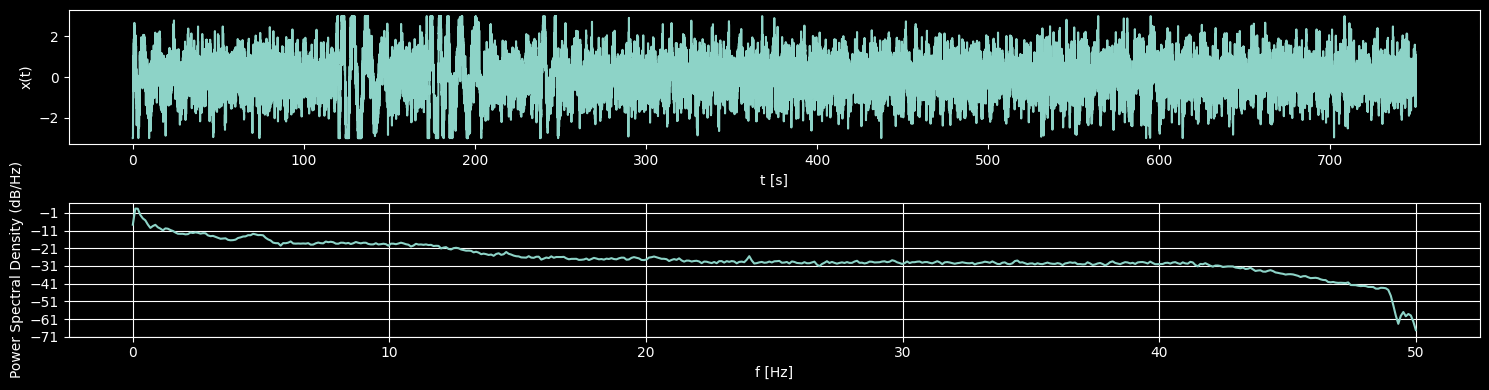

In [ ]:
subject = 15
channel = 12

if SMALL_DATASET: 
    subject = 2
plot_psd(data_clamped_train, subject=subject, channel=channel, fs=fs)

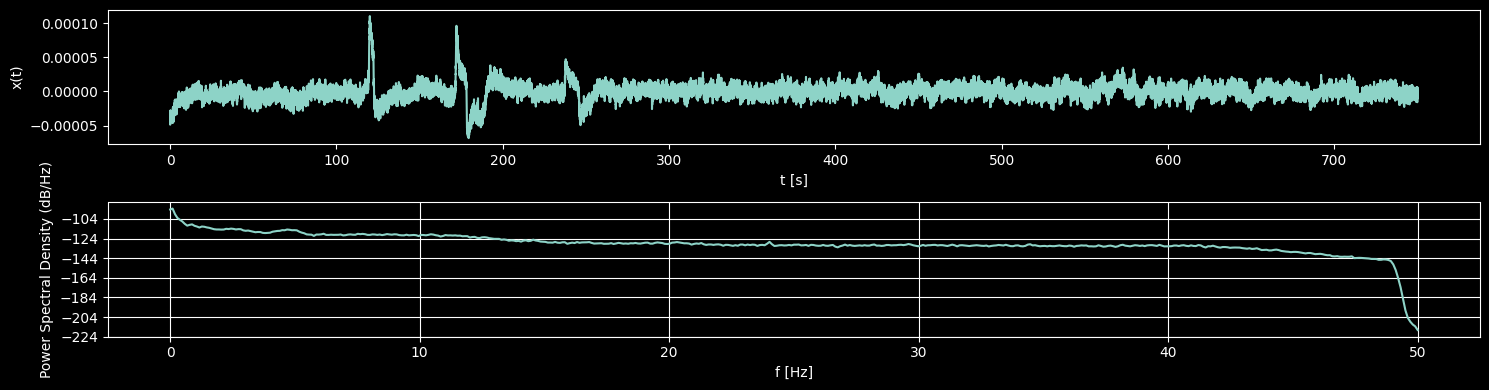

In [ ]:
plot_psd(data_filtered_lp, subject=subject, channel=channel, fs=fs)

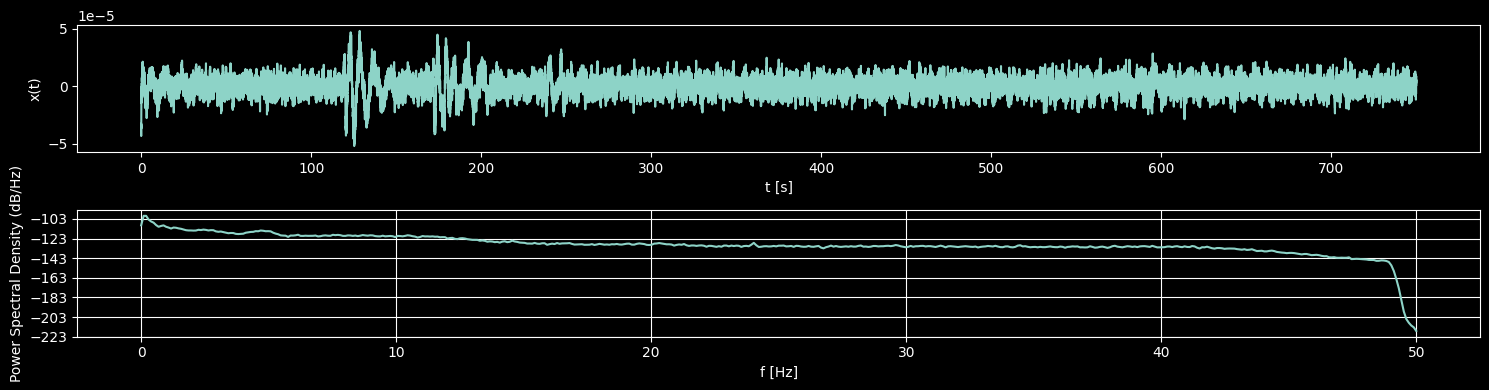

In [ ]:
plot_psd(data_filtered_lp_hp, subject=subject, channel=channel, fs=fs)

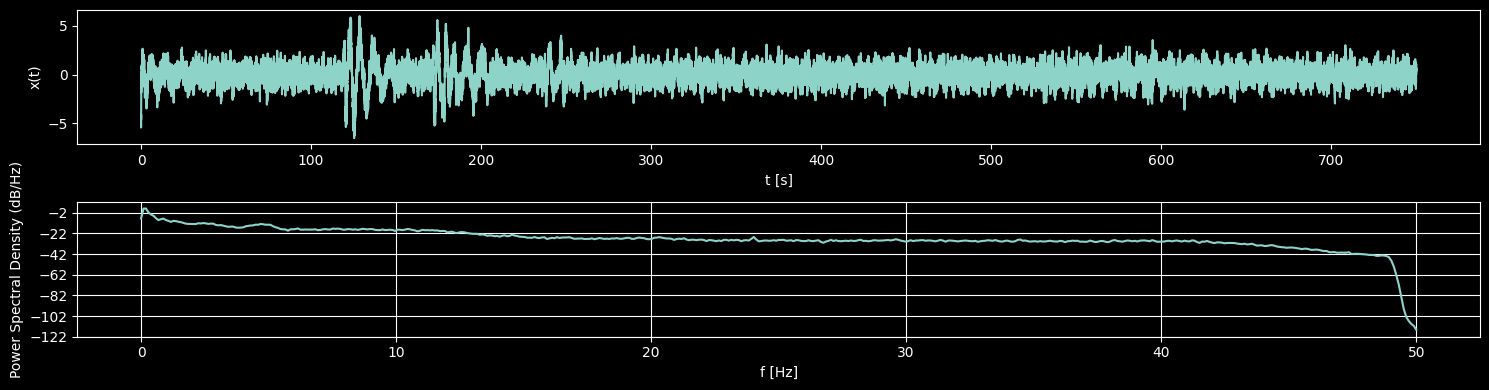

In [ ]:
plot_psd(data_normalized, subject=subject, channel=channel, fs=fs)

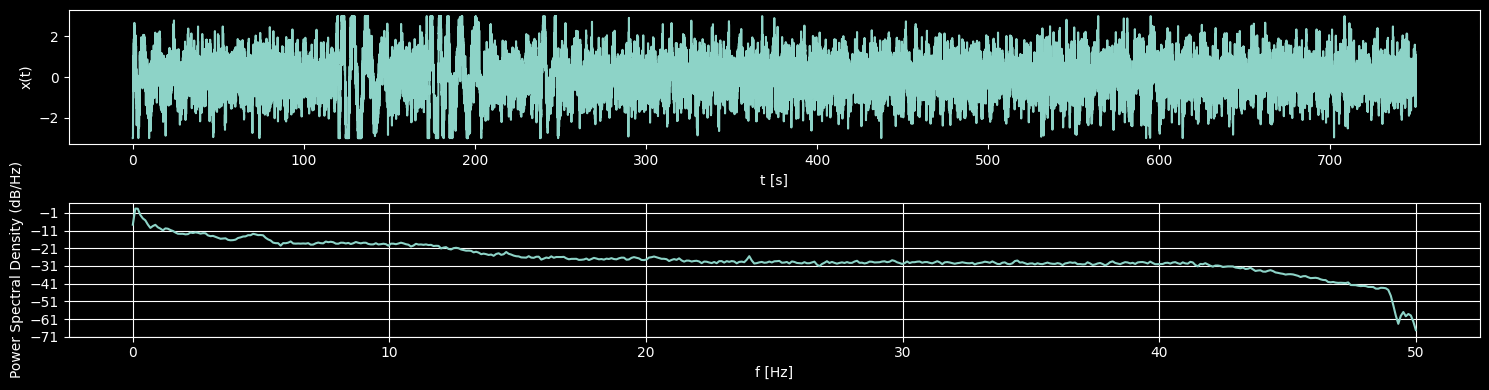

In [ ]:
plot_psd(data_clamped, subject=subject, channel=channel, fs=fs)

In [ ]:
labels_val_tensor

tensor([[68.]])

### Visualize data distribution

In [ ]:
labels_train_tensor = torch.load(os.path.join(save_path, "labels_raw_train.pt"))
labels_val_tensor = torch.load(os.path.join(save_path, "labels_raw_val.pt"))
labels_test_tensor = torch.load(os.path.join(save_path, "labels_raw_test.pt"))

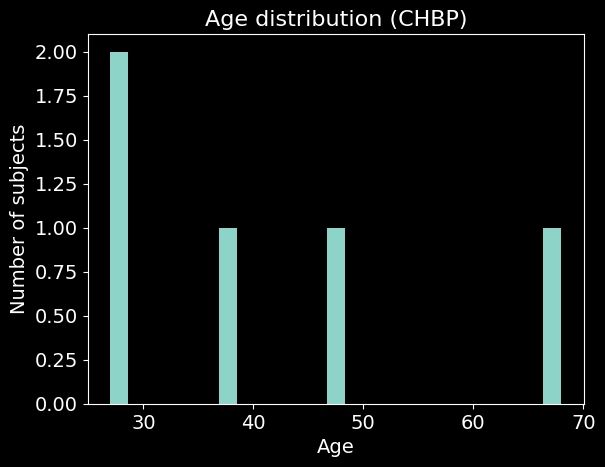

In [ ]:
# Generate example data
data = torch.cat([labels_train_tensor, labels_val_tensor, labels_test_tensor], dim=0).squeeze()

# Create a histogram
counts, bins, _ = plt.hist(data, bins=25)

# Add text annotations for non-zero absolute counts above each bar
for count, bin_edge in zip(counts, bins):
    if count != 0:
        plt.text(bin_edge + 1, count, str(int(count)), ha='center', va='bottom', fontsize=8, color='black')

# Add labels and title
plt.xlabel('Age', fontsize=14)
plt.ylabel('Number of subjects', fontsize=14)
plt.title('Age distribution (CHBP)', fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# plt.savefig('./figures/age_dist_lemon_all.png', transparent=True)

# Show the plot
plt.show()


TypeError: len() of a 0-d tensor

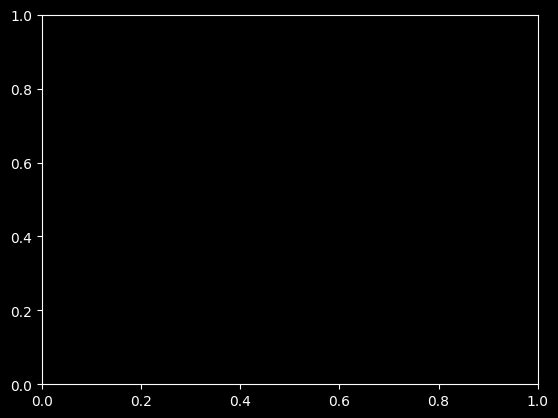

In [ ]:
# Generate example data
data = labels_test_tensor.squeeze()

# Create a histogram
counts, bins, _ = plt.hist(data, bins=25)

# Add text annotations for non-zero absolute counts above each bar
for count, bin_edge in zip(counts, bins):
    if count != 0:
        plt.text(bin_edge + 1, count, str(int(count)), ha='center', va='bottom', fontsize=8, color='black')

# Add labels and title
plt.xlabel('Age', fontsize=14)
plt.ylabel('Number of subjects', fontsize=14)
plt.title('Age distribution (CHBP test)', fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# plt.savefig('./figures/age_dist_lemon_test.png', transparent=True)

# Show the plot
plt.show()
